# Airdrops -- Exploratory Data Analysis

**[Johnnatan Messias](https://johnnatan-messias.github.io/), May 2025**.


In [1]:
# Standard Library Imports
import os
import gzip
import pickle
import json

# Third-Party Libraries
import polars as pl
import pandas as pd
from tqdm.notebook import tqdm
from IPython.display import display, HTML

# Polars Configuration
pl.Config.set_float_precision(18)

polars.config.Config

In [2]:
import sys
code_dir = os.path.realpath(os.path.join(os.getcwd(), "..", "src"))

sys.path.append(code_dir)

In [3]:
import plotly.graph_objects as go
from plot_utils import get_plotly_layout, colors, percentiles, ECDF
import networkx as nx

In [4]:
# protocols = ["ens", "dydx", "1inch", "gemstone", "arbitrum",
#              "optimism", "uniswap", "arkham", "lido", "tornado"]
protocols = ['1inch', 'arbitrum', 'arkham', 'dydx',
             'ens', 'lido', 'optimism', 'tornado', 'uniswap']

In [ ]:
# Define shared attributes to avoid redundancy
common_styles = {
    "width": [4.25, 4, 3.75, 3.5, 3.25, 3, 2.75, 2.5, 2.25, 2],
    "style": ["solid", "dash", "dot", "dashdot", "solid", "dash", "dash", "dot", "dashdot", "solid"]
}

labels = ['1inch', 'Arbitrum', 'Arkham', 'DYDX',
          'ENS', 'Lido', 'Optimism', 'TornadoCash', 'Uniswap']

colors_list = [
    colors["blue"], colors["red"], colors["green"], colors["grey"], colors["pink"],
    colors["orange"], colors["brown"], colors["light_yellow"], colors["black"], colors["purple"]
]

# Construct plot settings using a dictionary comprehension
plot_settings = {
    protocol: {
        "color": colors_list[i],
        "label": labels[i],
        "style": common_styles["style"][i],
        "width": common_styles["width"][i]
    }
    for i, protocol in enumerate(protocols)
}

In [6]:
data_dir = os.path.realpath(os.path.join(os.getcwd(), "..", "data"))
plots_dir = os.path.realpath(os.path.join(data_dir, "..", "plots"))
graph_dir = os.path.join(data_dir, "graphs")

os.makedirs(data_dir, exist_ok=True)
os.makedirs(plots_dir, exist_ok=True)
os.makedirs(graph_dir, exist_ok=True)

In [7]:
# Loading dead/null addresses
dead_addresses = pl.read_csv(os.path.join(
    data_dir, "dead_addresses.csv"))['address']

In [8]:
decimals = 1e18

# Loading data


In [9]:
from pathlib import Path


def load_dataset(protocols):
    # Define base data directory
    base_path = Path(data_dir)

    # Load datasets using dictionary comprehension
    return {
        protocol: {
            'transfer': pl.scan_parquet(base_path / f"{protocol}_transfer.parquet"),
            'claim': pl.scan_parquet(base_path / f"{protocol}_claim.parquet")
        }
        for protocol in tqdm(protocols)
    }

In [10]:
# Load the dataset once
dfs = load_dataset(protocols)

# Define protocols with 'to' as receiver in claim
to_receiver_protocols = {"1inch", "uniswap", "lido", "tornado", "optimism"}

for protocol, data in dfs.items():
    print(protocol)

    # Rename for 'transfer'
    data['transfer'] = data['transfer'].rename(
        {"from": "sender", "to": "receiver"})

    # Determine claim renaming based on protocol
    claim_rename = {"to": "receiver"} if protocol in to_receiver_protocols else {
        "account": "receiver"}

    # Apply renaming for 'claim'
    data['claim'] = data['claim'].rename(claim_rename)

  0%|          | 0/9 [00:00<?, ?it/s]

1inch
arbitrum
arkham
dydx
ens
lido
optimism
tornado
uniswap


In [11]:
for protocol, data in dfs.items():
    print(protocol)

    for data_type in ["claim", "transfer"]:
        result = (
            data[data_type]
            .select([
                pl.min('timestamp').alias("min_timestamp"),
                pl.max('timestamp').alias("max_timestamp")
            ])
            .collect()
        )

        min_timestamp = result["min_timestamp"].item()
        max_timestamp = result["max_timestamp"].item()

        print(f"\t{data_type}: min_date={min_timestamp}\tmax_date={max_timestamp}")

1inch
	claim: min_date=2020-12-25 00:08:54	max_date=2024-10-18 21:35:47
	transfer: min_date=2020-12-23 18:13:31	max_date=2024-10-19 13:45:47
arbitrum
	claim: min_date=2023-03-23 13:01:22+00:00	max_date=2023-09-24 20:12:52+00:00
	transfer: min_date=2023-03-16 12:08:28+00:00	max_date=2024-05-14 23:59:58+00:00
arkham
	claim: min_date=2023-07-18 07:41:35	max_date=2024-09-13 10:37:11
	transfer: min_date=2023-07-05 15:44:59	max_date=2024-10-19 13:15:11
dydx
	claim: min_date=2021-09-08 05:24:48	max_date=2024-10-18 18:32:35
	transfer: min_date=2021-07-12 01:37:12	max_date=2024-10-19 13:45:47
ens
	claim: min_date=2021-11-09 00:01:26	max_date=2024-08-04 04:28:23
	transfer: min_date=2021-11-01 20:55:17	max_date=2024-10-19 13:35:47
lido
	claim: min_date=2021-01-05 18:16:51	max_date=2024-09-15 01:53:23
	transfer: min_date=2020-12-17 22:12:05	max_date=2024-10-19 13:44:47
optimism
	claim: min_date=2022-05-31 14:39:05	max_date=2023-07-11 21:41:05
	transfer: min_date=2022-04-26 13:42:36	max_date=2024-0

In [12]:
for protocol, data in dfs.items():
    print(protocol)
    for data_type in ["claim", "transfer"]:
        result = (
            data[data_type]
            .select([
                pl.min('blockNumber').alias("min_block"),
                pl.max('blockNumber').alias("max_block")
            ])
            .collect()
        )

        min_block = result["min_block"].item()
        max_block = result["max_block"].item()

        print(f"\t{data_type}: min_block={min_block}\tmax_block={max_block}")

1inch
	claim: min_block=11519481	max_block=20995174
	transfer: min_block=11511393	max_block=21000000
arbitrum
	claim: min_block=72829612	max_block=134244706
	transfer: min_block=70398215	max_block=211336634
arkham
	claim: min_block=17718694	max_block=20741142
	transfer: min_block=17628655	max_block=20999848
dydx
	claim: min_block=13183164	max_block=20994261
	transfer: min_block=12809555	max_block=21000000
ens
	claim: min_block=13578843	max_block=20452797
	transfer: min_block=13533418	max_block=20999950
lido
	claim: min_block=11596109	max_block=20752853
	transfer: min_block=11473276	max_block=20999995
optimism
	claim: min_block=9401026	max_block=106756444
	transfer: min_block=6491116	max_block=117863006
tornado
	claim: min_block=11474827	max_block=15322201
	transfer: min_block=11474599	max_block=20999592
uniswap
	claim: min_block=10875578	max_block=20999937
	transfer: min_block=10861674	max_block=20999993


In [13]:
for protocol, data in dfs.items():
    transfer_count = data['transfer'].select(pl.len()).collect().item()
    claim_count = data['claim'].select(pl.len()).collect().item()

    print(
        f"There are {transfer_count} Transfer and {claim_count} claiming events for {protocol}")

There are 1782998 Transfer and 43806 claiming events for 1inch
There are 47330340 Transfer and 583137 claiming events for arbitrum
There are 283775 Transfer and 64724 claiming events for arkham
There are 747372 Transfer and 72870 claiming events for dydx
There are 998619 Transfer and 102824 claiming events for ens
There are 1107586 Transfer and 516 claiming events for lido
There are 43990557 Transfer and 160603 claiming events for optimism
There are 278455 Transfer and 5474 claiming events for tornado
There are 4872925 Transfer and 221087 claiming events for uniswap


In [14]:
for protocol, data in dfs.items():
    claim_count = data['claim'].select(
        pl.n_unique('receiver')).collect().item()
    print(f"{protocol}: There are {claim_count} accounts receiving the airdrop")

1inch: There are 43806 accounts receiving the airdrop
arbitrum: There are 583137 accounts receiving the airdrop
arkham: There are 64719 accounts receiving the airdrop
dydx: There are 45944 accounts receiving the airdrop
ens: There are 102824 accounts receiving the airdrop
lido: There are 507 accounts receiving the airdrop
optimism: There are 160603 accounts receiving the airdrop
tornado: There are 5347 accounts receiving the airdrop
uniswap: There are 221087 accounts receiving the airdrop


### EDA


In [15]:
rows = (
    dfs['ens']['claim']
    .select(["receiver", "amount", "transactionHash"])
    .sort("amount", descending=True)
    .head()
    .collect()
)

# Iterate through rows and print
for row in rows.iter_rows(named=True):
    print(row["receiver"], row["amount"], row["transactionHash"])

0x72e34d8030466a5e0bf1df0e6b85930e839b3c04 1143.5442044346885 c1de65093faae18fe569bbc2d10813e15f69a0748cf90fbcc20faaab593668d5
0xfc8eba4edfe1aca993ab195c6572a66e1b314b9b 1143.5442044346885 8400934c8e26072b8b9218efc221c6d70ed84c754c539dc05ed9bb3c26663b3d
0x34aa3f359a9d614239015126635ce7732c18fdf3 1143.5442044346885 48e6ae2479ac3d218de557a3b3eff0a4583da6986272d8cc0dcd6606b210f46e
0x57f74df0235f23e483bacfbd30f6972ffeb02f1e 1143.5442044346885 7a0c9899d4e16c281618a770c265cdfd754d714c1aab0ce08ac80a18df0fdd02
0x4007ce2083c7f3e18097aeb3a39bb8ec149a341d 1143.5442044346885 88aa3c302fe81704c7c505ad0d0e9a4035643e46b98918fee420317db9b27819


The total amount of tokens claimed for 1inch was 83642822.40415813.


,count,mean,std,min,1%,5%,10%,20%,25%,50%,75%,80%,90%,95%,99%,max
amount,43806.0,1909.391919,49932.960031,6.104267e-08,5.882978,600.39264,602.703124,606.128554,608.806022,636.441842,777.912938,863.277394,1367.644224,2485.792165,12636.917217,9.749686e+06


The total amount of tokens claimed for arbitrum was 1092811500.0.


,count,mean,std,min,1%,5%,10%,20%,25%,50%,75%,80%,90%,95%,99%,max
amount,583137.0,1874.021885,1566.916169,625.0,625.0,625.0,625.0,875.0,875.0,1250.0,2250.0,2500.0,3750.0,5250.0,8500.0,10250.0


The total amount of tokens claimed for arkham was 29394517.342645075.


,count,mean,std,min,1%,5%,10%,20%,25%,50%,75%,80%,90%,95%,99%,max
amount,64724.0,454.151742,2348.942885,1.974295,197.429455,197.429455,197.429455,197.429455,197.429455,197.429455,197.429455,197.429455,789.717821,1776.865098,3553.730196,249353.402081


The total amount of tokens claimed for dydx was 167511962.49729607.


,count,mean,std,min,1%,5%,10%,20%,25%,50%,75%,80%,90%,95%,99%,max
amount,72870.0,2298.778132,19599.978825,5.800000e-17,4.073383,26.275409,54.631973,136.267241,201.341671,562.235451,1164.33635,1258.375547,4349.63,6413.91,19982.242277,1.492217e+06


The total amount of tokens claimed for ens was 19632454.199476592.


,count,mean,std,min,1%,5%,10%,20%,25%,50%,75%,80%,90%,95%,99%,max
amount,102824.0,190.932605,141.565438,0.000133,17.186991,35.891491,52.73558,77.582431,92.634439,152.39887,252.965299,282.287304,389.077185,443.793941,696.211535,1143.544204


The total amount of tokens claimed for lido was 3971044.797424059.


,count,mean,std,min,1%,5%,10%,20%,25%,50%,75%,80%,90%,95%,99%,max
amount,516.0,7695.823251,53597.399835,0.000871,5.830487,17.421297,23.2072,36.480394,55.992595,238.307466,1034.32183,1484.441504,4273.828953,12722.842519,126812.41946,746286.490915


The total amount of tokens claimed for optimism was 166252055.5245812.


,count,mean,std,min,1%,5%,10%,20%,25%,50%,75%,80%,90%,95%,99%,max
amount,160603.0,1035.174035,1528.644811,9.620727e-08,271.833779,271.833779,271.833779,409.426293,409.426293,776.867362,776.867362,1186.293655,2469.358092,2469.358092,7331.165119,32431.799505


The total amount of tokens claimed for tornado was 500000.00000000006.


,count,mean,std,min,1%,5%,10%,20%,25%,50%,75%,80%,90%,95%,99%,max
amount,5474.0,91.340884,1948.052299,0.0,0.0,0.762542,2.899245,5.604079,8.7317,21.7204,59.365266,76.611403,147.516963,271.944796,704.688972,143831.157593


The total amount of tokens claimed for uniswap was 137040499.27698204.


,count,mean,std,min,1%,5%,10%,20%,25%,50%,75%,80%,90%,95%,99%,max
amount,221087.0,619.848744,9330.267753,400.0,400.0,400.0,400.0,400.0,400.0,400.0,400.0,400.0005,402.274533,422.07402,1392.09398,2.103517e+06


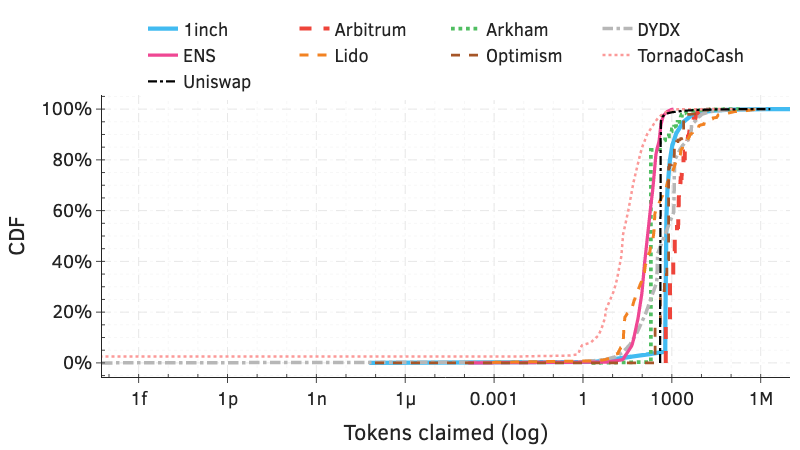

In [57]:
# Initialize the figure
fig = go.Figure(layout=get_plotly_layout(width=800, height=450))

for protocol in protocols:
    # Collect data once for the selected columns
    data = (
        dfs[protocol]['claim']
        .select(["timestamp", "amount"])
        .collect()
    )

    # Display protocol information and summary statistics
    display(HTML(f"<h3>{protocol}</h3>"))
    total_claimed = data['amount'].sum()
    print(
        f"The total amount of tokens claimed for {protocol} was {total_claimed}.")

    # Display descriptive statistics
    display(data['amount'].to_pandas().describe(
        percentiles=percentiles).to_frame().T)

    # Calculate ECDF using a single pass
    amounts = data["amount"].to_numpy()
    ecdf = ECDF(amounts)

    # Add ECDF trace to the plot
    fig.add_trace(go.Scatter(
        x=ecdf.x,
        y=ecdf.y,
        name=plot_settings[protocol]['label'],
        line=dict(
            color=plot_settings[protocol]['color'],
            width=plot_settings[protocol]['width'],
            dash=plot_settings[protocol]['style']
        )
    ))

# Update layout
fig.update_layout(
    xaxis_title='Tokens claimed (log)',
    yaxis_title='CDF',
    legend=dict(xanchor='center', x=0.5, y=1.3, orientation='h')
)
fig.update_xaxes(type='log')
fig.update_yaxes(tickformat=".0%")

# Display the plot
fig.show("png")

In [17]:
# Analysis of the Top Earners
for protocol in protocols:
    claims = dfs[protocol]['claim'].collect()

    # Extract top earner and their claimed amount
    top_earner = claims.sort('amount', descending=True).head(1)
    amount_claimed = top_earner['amount'].item()
    receiver = top_earner['receiver'].item()

    # Calculate total tokens airdropped
    total_tokens_airdroped = claims['amount'].sum()

    # Calculate percentage claimed by the top earner
    percentage_claimed = 100 * amount_claimed / \
        total_tokens_airdroped if total_tokens_airdroped != 0 else 0

    # Print the results
    print(
        f"{protocol:<15} | Amount Claimed: {amount_claimed:>15,.2f} | Receiver: {receiver:<42} | Percentage: {percentage_claimed:>6.3f}% | Transaction: {top_earner['transactionHash'].item()} | Total airdrop: {total_tokens_airdroped:,.2f}")

1inch           | Amount Claimed:    9,749,686.00 | Receiver: 0xa0f75491720835b36edc92d06ddc468d201e9b73 | Percentage: 11.656% | Transaction: b9cdd3c726984ce876ade2581a3cf130e5fd4eb9d14a85b157d43e5abf3c155e | Total airdrop: 83,642,822.40
arbitrum        | Amount Claimed:       10,250.00 | Receiver: 0x79f06c6b737b65b800efc87d9e97a90b8bbb2b3f | Percentage:  0.001% | Transaction: 0xe12e4da6ea6674078b9a78ebda4b422f94050aa453e32492dd70aa9defae2ace | Total airdrop: 1,092,811,500.00
arkham          | Amount Claimed:      249,353.40 | Receiver: 0xf0dff6c2c30ba13a2cb43e048fa7f98b1bc38d2f | Percentage:  0.848% | Transaction: 161cbff62dc298ef8083e0373b6619bc8c67ab7a1b1203504400b78c3f5a3629 | Total airdrop: 29,394,517.34
dydx            | Amount Claimed:    1,492,217.38 | Receiver: 0xa6159589a0c2449fdb89017abdd43493496d2d92 | Percentage:  0.891% | Transaction: 7c9e8a62b1f1b5dea00cf9321b4020c1ff4ec0f235d72a8d9d081622194a6db4 | Total airdrop: 167,511,962.50
ens             | Amount Claimed:        1

In [18]:
for protocol, data in dfs.items():
    result = (
        data['claim']
        .select([
            pl.max('amount').alias("max_amount"),
            pl.sum('amount').alias("total_amount")
        ])
        .collect()
    )

    top_earner = result["max_amount"].item()
    total_amount = result["total_amount"].item()
    percentage = round(100 * top_earner / total_amount, 2)

    print(
        f"The top earner for {protocol} earned {top_earner} tokens, representing {percentage}% of all tokens distributed.")

The top earner for 1inch earned 9749686.003287062 tokens, representing 11.66% of all tokens distributed.
The top earner for arbitrum earned 10250.0 tokens, representing 0.0% of all tokens distributed.
The top earner for arkham earned 249353.4020813408 tokens, representing 0.85% of all tokens distributed.
The top earner for dydx earned 1492217.3787069707 tokens, representing 0.89% of all tokens distributed.
The top earner for ens earned 1143.5442044346885 tokens, representing 0.01% of all tokens distributed.
The top earner for lido earned 746286.4909149566 tokens, representing 18.79% of all tokens distributed.
The top earner for optimism earned 32431.799504666036 tokens, representing 0.02% of all tokens distributed.
The top earner for tornado earned 143831.1575925667 tokens, representing 28.77% of all tokens distributed.
The top earner for uniswap earned 2103516.5902480003 tokens, representing 1.53% of all tokens distributed.


## Airdrop list

Lido list (https://docs.lido.fi/guides/1inch-pool-rewards):

- https://github.com/lidofinance/airdrop-data/blob/main/early_stakers_airdrop.csv
- https://github.com/lidofinance/airdrop-data/blob/main/oneinch_lido_airdrop.csv

Tornado list: https://github.com/tornadocash/airdrop/blob/master/airdrop.csv


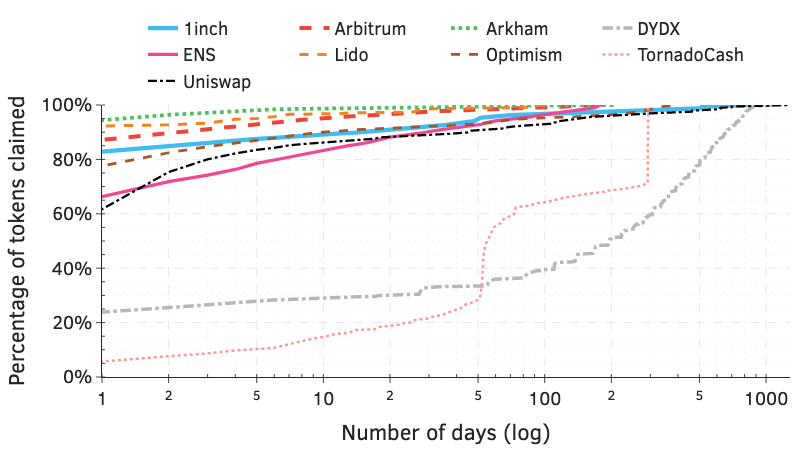

In [59]:
# Setup figure
fig = go.Figure(layout=get_plotly_layout(width=800, height=450))

for protocol in protocols:
    df = (
        dfs[protocol]['claim']
        .with_columns(pl.col("timestamp").cast(pl.Date).alias("date"))
        .group_by("date")
        .agg(pl.sum("amount").alias("daily_sum"))
        .sort("date")
        .with_columns([
            pl.col("daily_sum").cum_sum().alias("cumulative_sum"),
            pl.col("daily_sum").sum().alias("total_sum")
        ])
        .with_columns(
            (pl.col("cumulative_sum") / pl.col("total_sum")).alias("claimed_fraction")
        )
        .with_row_index(name="days_since_start")
        .select(["days_since_start", "claimed_fraction"])
        .collect()
    )

    fig.add_trace(go.Scatter(
        x=df["days_since_start"],
        y=df["claimed_fraction"],
        mode="lines",
        line=dict(
            color=plot_settings[protocol]['color'],
            width=plot_settings[protocol]['width'],
            dash=plot_settings[protocol]['style']
        ),
        name=plot_settings[protocol]['label']
    ))

# Update layout
fig.update_layout(
    xaxis_title="Number of days (log)",
    yaxis_title="Percentage of tokens claimed",
    legend=dict(xanchor="center", x=0.5, y=1.35, orientation="h"))

fig.update_xaxes(type="log")
fig.update_yaxes(tickformat=".0%", range=[0, 1])

# Export and display
fig.write_image(os.path.join(plots_dir, "tokens_claimed_per_day.pdf"))
fig.show("png")

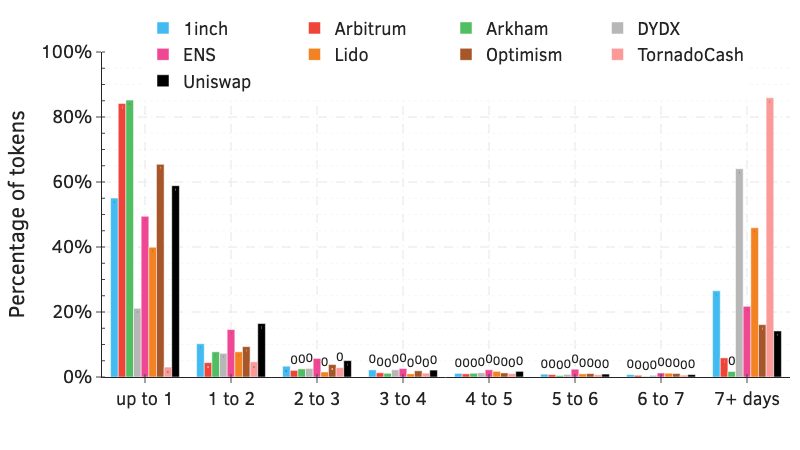

In [20]:
# Constants
bins = [0, 24, 48, 72, 96, 120, 144, 168]
bin_labels = ['up to 1', '1 to 2', '2 to 3',
              '3 to 4', '4 to 5', '5 to 6', '6 to 7', '7+ days']

# Plot setup
fig = go.Figure(layout=get_plotly_layout(width=800, height=450))

for protocol in protocols:
    # Compute delay in hours
    df = (
        dfs[protocol]['claim']
        .select(["timestamp", "amount"])
        .with_columns(
            (pl.col("timestamp") - pl.col("timestamp").min()
             ).dt.total_hours().alias("claim_delay_hour")
        )
        .collect()
    )

    # Bin and compute percentages
    binned = (
        df.select(pl.col("claim_delay_hour").cut(
            breaks=bins, left_closed=True).alias("bin"))
        .group_by("bin")
        .agg(pl.len().alias("count"))
        .with_columns(
            (pl.col("count") / pl.col("count").sum()).alias("percentage")
        )
        .sort("bin")
    )

    # Add bar to figure
    fig.add_trace(go.Bar(
        x=bin_labels,
        y=binned["percentage"],
        marker_color=plot_settings[protocol]['color'],
        text=binned["percentage"].round(1),
        textposition='auto',
        name=plot_settings[protocol]['label']
    ))

# Finalize plot
fig.update_layout(
    yaxis_title="Percentage of tokens",
    xaxis_title="",
    legend=dict(xanchor='center', x=0.5, y=1.13, orientation='h'),
)
fig.update_yaxes(range=[0, 1], tickformat=".0%")

# Save and show
fig.write_image(os.path.join(plots_dir, "claim_delay.pdf"))
fig.show("png")

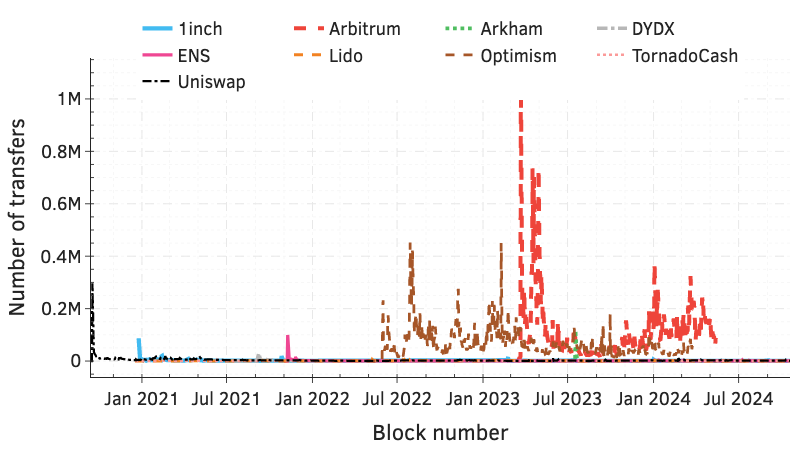

In [21]:
fig = go.Figure(layout=get_plotly_layout(width=800, height=450))

# Precompute dead address set once (if large) for faster membership checks
dead_address_set = set(dead_addresses)

for protocol in protocols:
    df = (
        dfs[protocol]['transfer']
        # Fast filtering
        .filter(~pl.col('sender').is_in(dead_address_set))
        # Convert once, reuse column
        .with_columns(pl.col('timestamp').cast(pl.Date).alias("date"))
        # Group by date directly
        .group_by('date')
        # Count all rows
        .agg(pl.len().alias('transfer_count'))
        # Chronological order
        .sort('date')
        .collect()
    )

    fig.add_trace(go.Scatter(
        x=df['date'],
        y=df['transfer_count'],
        mode='lines',
        line=dict(
            color=plot_settings[protocol]['color'],
            width=plot_settings[protocol]['width'],
            dash=plot_settings[protocol]['style']
        ),
        name=plot_settings[protocol]['label']
    ))

fig.update_layout(
    xaxis_title='Block number',
    yaxis_title='Number of transfers',
    legend=dict(xanchor='center', x=0.5, y=1.15, orientation='h')
)

fig.show("png")

## Graph network analysis


In [22]:
# Consider only transfers realized after the block timestamp!!!

In [23]:
# Loading exchange addresses
# Define data paths
cex_path = os.path.join(data_dir, "cex_addresses.csv")
dex_path = os.path.join(data_dir, "dex_addresses.csv")

# Load data
exchange_cex_addresses_df = pl.read_csv(cex_path)
exchange_dex_addresses_df = pl.read_csv(dex_path)

# Union set of the exchanges
exchange_addresses_set = set(exchange_cex_addresses_df['address'].to_list(
) + exchange_dex_addresses_df['address'].to_list())

# Output the number of addresses
print(
    f"There are {exchange_cex_addresses_df['address'].unique().len()} CEX addresses and {exchange_dex_addresses_df['address'].unique().len()} DEX addresses.")

print(f"There are {len(exchange_addresses_set)} exchange addresses in total.")

# Adding fake exchange created during the Gemstone airdrop attack.
exchange_addresses_set.add('0x7aa1ed8fb5e820e38c86cf3dd0a9eb0169a149ad')

There are 3011 CEX addresses and 558 DEX addresses.
There are 3569 exchange addresses in total.


In [24]:
exchange_cex_dict = {
    row["address"]: {"name": row["name"],
                     "distinct_name": row["distinct_name"]}
    for row in exchange_cex_addresses_df.iter_rows(named=True)
}

exchange_dex_dict = {
    row["address"]: {"name": row["name"],
                     "distinct_name": row["distinct_name"]}
    for row in exchange_dex_addresses_df.iter_rows(named=True)
}

In [25]:
# addresses = dict()
# exchanges = dict()
# filedir = os.path.realpath(os.path.join(data_dir, "addresses_dic.json"))
# with open(filedir) as f:
#     addresses = json.load(f)
#     ads = list(addresses.keys())
#     for address in ads:
#         addresses[address.lower()] = addresses.pop(address)

# filedir = os.path.realpath(os.path.join(data_dir, "addresses.json"))
# with open(data_dir+filedir) as f:
#     addresses.update(json.load(f))
#     ads = list(addresses.keys())
#     for address in ads:
#         addresses[address.lower()] = addresses.pop(address)

# filedir = os.path.realpath(os.path.join(data_dir, "exchange_addresses.json"))
# with open(filedir) as f:
#     data = json.load(f)
#     for address in data.keys():
#         exchanges[address.lower()] = data[address]

# addresses.update(exchanges)
# print("There are {} exchanges addresses".format(len(exchanges)))
# print("There are {} addresses".format(len(addresses)))

In [26]:
# exchanges['0x1df4139144595e0245b084e7ea1a75101fb95548'] = 'Uniswap V2: 1INCH-DAI'
# exchanges['0xad570798fa568d93c52ee0f9839278959b13a49b'] = 'Uniswap V3: DYDX-USDT'
# exchanges['0x65f7ba4ec257af7c55fd5854e5f6356bbd0fb8ec'] = 'stkDYDX'
# exchanges['0x9687ec962a3a3f72e2c3b7604c31ccc7d1eec84a'] = 'Gemstone-to-check'
# exchanges['0xef523713706b93a31cfd083a2fe47847b714be55'] = 'Gemstone-to-check'
# exchanges['0x92fd143a8fa0c84e016c2765648b9733b0aa519e'] = 'Uniswap V3 - ARB/WETH' # Arbitrum
# exchanges['0xa8328bf492ba1b77ad6381b3f7567d942b000baf'] = 'Uniswap - ARB/USDC'
# exchanges['0x64768a3a2453f1e8de9e43e92d65fc36e4c9872d'] = 'Uniswap ARB-WETH'
# exchanges['0xfd086bc7cd5c481dcc9c85ebe478a1c0b69fcbb9'] = 'Uniswap - ARB/USDT'
# exchanges['0xc18360217d8f7ab5e7c516566761ea12ce7f9d72'] = 'ENS'
# exchanges['0x833af8617d03902efb4cc6f2eaa4d58ace6d3fc6'] = 'Gemstone'
# exchanges['0xc18360217d8f7ab5e7c516566761ea12ce7f9d72'] = 'ENS'

In [27]:
dfs['dydx']['transfer'].filter(
    pl.col('sender').eq('0x639192d54431f8c816368d3fb4107bc168d0e871')
).collect()

blockNumber,transactionHash,blockHash,address,transactionIndex,logIndex,event,sender,receiver,amount,timestamp
i64,str,str,str,i64,i64,str,str,str,f64,datetime[ns]
13183164,"""361400ec679147ed4575ac2215de48…","""66eebcd18b681919affcf267100740…","""0x92d6c1e31e14520e676a687f0a93…",18,35,"""Transfer""","""0x639192d54431f8c816368d3fb410…","""0x54af6a1dbacfa9dddd72a7dd1b4f…",1.584922969314624952e-1,2021-09-08 05:24:48
13185646,"""53629569beb5d8dd590edc169ea093…","""c9adf2ffc238e0fe42ad28cad4fb74…","""0x92d6c1e31e14520e676a687f0a93…",118,184,"""Transfer""","""0x639192d54431f8c816368d3fb410…","""0x75dc9a12bf02565136ddf3e27fcb…",0.000000000000000000e0,2021-09-08 14:23:45
13185813,"""751c7b32ba3ed77f59dc2776a910dc…","""bab2daf7004c944c5311039628208f…","""0x92d6c1e31e14520e676a687f0a93…",23,100,"""Transfer""","""0x639192d54431f8c816368d3fb410…","""0x8568e1a8082b442ae9be089a3b38…",1.178209769696859667e3,2021-09-08 15:00:53
13185813,"""f1664ae2da908ee8a71e88afe86d25…","""bab2daf7004c944c5311039628208f…","""0x92d6c1e31e14520e676a687f0a93…",156,240,"""Transfer""","""0x639192d54431f8c816368d3fb410…","""0x44acd0ff3be9fdfb932453c82b5d…",4.350810345703857820e3,2021-09-08 15:00:53
13185813,"""0f6a0ed8d5e6854709e12d57bb65b6…","""bab2daf7004c944c5311039628208f…","""0x92d6c1e31e14520e676a687f0a93…",158,252,"""Transfer""","""0x639192d54431f8c816368d3fb410…","""0xf7e39bfa90e8501fe2f2a1333e3e…",1.163646413569437755e3,2021-09-08 15:00:53
…,…,…,…,…,…,…,…,…,…,…
20980742,"""0b816841fe4e141a34c1cf8eeb5c0d…","""b6b23bceb44d7571f4962167f57555…","""0x92d6c1e31e14520e676a687f0a93…",10,59,"""Transfer""","""0x639192d54431f8c816368d3fb410…","""0x625ceba7f2fa59a6b10cfaed5c54…",8.055714889045527798e2,2024-10-16 21:14:47
20981977,"""ddcb3f6cc695249f4efef243791764…","""eb36ea2f0a2ae5a74aa7926e6c0a86…","""0x92d6c1e31e14520e676a687f0a93…",86,249,"""Transfer""","""0x639192d54431f8c816368d3fb410…","""0xd33211514b5ec7169236bdff3081…",0.000000000000000000e0,2024-10-17 01:23:35
20981977,"""ddcb3f6cc695249f4efef243791764…","""eb36ea2f0a2ae5a74aa7926e6c0a86…","""0x92d6c1e31e14520e676a687f0a93…",86,257,"""Transfer""","""0x639192d54431f8c816368d3fb410…","""0xd33211514b5ec7169236bdff3081…",5.718525010304958414e4,2024-10-17 01:23:35


In [28]:
airdrop_contracts = {
    "ens": {"0xc18360217d8f7ab5e7c516566761ea12ce7f9d72"},
    "dydx": {"0x639192d54431f8c816368d3fb4107bc168d0e871"},
    "1inch": {"0xe295ad71242373c37c5fda7b57f26f9ea1088afe"},
    "gemstone": {"0xdea197d9920a7472050013ad7e8de0733da81d5c"},
    "arbitrum": {"0x67a24ce4321ab3af51c2d0a4801c3e111d88c9d9"},
    "optimism": {"0xfedfaf1a10335448b7fa0268f56d2b44dbd357de"},
    "uniswap": {"0x090d4613473dee047c3f2706764f49e0821d256e"},
    "arkham": {"0x08c7676680f187a31241e83e6d44c03a98adab05"},
    "lido": {"0x4b3edb22952fb4a70140e39fb1add05a6b49622b", "0xdb46c277da1599390eab394327602889e9546296"},
    "tornado": {"0x3efa30704d2b8bbac821307230376556cf8cc39e"},
}

# For dYdX see the transfer event on the following transaction hash: https://etherscan.io/tx/0x361400ec679147ed4575ac2215de486c09e03994f5cc310f2648942f4e0abb82#eventlog

In [29]:
# Function to build graph for a protocol
def build_graph(data, protocol, airdrop_addresses):
    G = nx.MultiDiGraph(protocol=protocol)
    for row in data.iter_rows(named=True):
        if row['sender'] in airdrop_addresses:
            continue
        G.add_edge(
            row['sender'], row['receiver'],
            amount=row['amount'],
            timestamp=str(row['timestamp']),
            block_number=row['blockNumber']
        )
    return G

In [30]:
# Generate Graph Networks
Gs = {}
for protocol in tqdm(protocols, desc='Generating graph network'):
    print(f"Processing protocol: {protocol}")
    airdrop_addresses = airdrop_contracts.get(protocol, set())

    # Efficient data filtering
    data = (
        dfs[protocol]['transfer']
        .filter(~pl.col('sender').is_in(dead_addresses))
        .collect()
    )

    # Build graph
    Gs[protocol] = build_graph(data, protocol, airdrop_addresses)

    print(
        f"Protocol {protocol}: {Gs[protocol].number_of_nodes()} nodes, {Gs[protocol].number_of_edges()} edges"
    )

Generating graph network:   0%|          | 0/9 [00:00<?, ?it/s]

Processing protocol: 1inch
Protocol 1inch: 370372 nodes, 1739191 edges
Processing protocol: arbitrum
Protocol arbitrum: 2789879 nodes, 46747201 edges
Processing protocol: arkham
Protocol arkham: 129012 nodes, 219050 edges
Processing protocol: dydx
Protocol dydx: 181000 nodes, 658614 edges
Processing protocol: ens
Protocol ens: 229991 nodes, 895792 edges
Processing protocol: lido
Protocol lido: 127754 nodes, 1107066 edges
Processing protocol: optimism
Protocol optimism: 1993397 nodes, 43829952 edges
Processing protocol: tornado
Protocol tornado: 34536 nodes, 272973 edges
Processing protocol: uniswap
Protocol uniswap: 1355596 nodes, 4651837 edges


In [ ]:
# Persist graphs
import pickle
for protocol, graph in tqdm(Gs.items()):
    graph_output = os.path.join(graph_dir, f"full_graph_{protocol}.gpickle")
    with gzip.open(graph_output, 'wb') as f:
        pickle.dump(graph, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
addresses = set()
n_nodes = 150

# Iterate through each protocol in the graph data
for protocol, graph in Gs.items():
    # Extract the top 100 nodes by in-degree and convert to a DataFrame
    top_nodes = sorted(graph.in_degree(),
                       key=lambda x: x[1], reverse=True)[:n_nodes]
    data = pd.DataFrame(top_nodes, columns=["node", "degree"])
    addresses.update(data['node'].to_list())

    # Display the protocol and its top nodes
    # print(f"Protocol: {protocol}")
    # display(data)

# Output the total number of unique addresses
print("Total number of unique addresses:", len(addresses))

# Save the addresses to a CSV file
file_path = os.path.join(data_dir, "addresses_to_check.json")
with open(file_path, "w") as file:
    json.dump(list(addresses), file)

### Build a subgraph for each protocol containing only the claimers first transfers.

This is useful to plot the graphs


In [ ]:
def show_graph_info(graph):
    print(f"Graph {graph.graph.get('protocol', 'Unknown')}")
    print(f"Nodes: {graph.number_of_nodes()}, Edges: {graph.number_of_edges()}")
    components = list(nx.connected_components(graph.to_undirected()))
    print(f"Connected Components: {len(components)}")
    if components:
        print(f"Largest Component Size: {len(max(components, key=len))}")


def subgraph_by_timestamp(G, t_start=float('-inf'), t_end=float('inf')):
    """
    Returns a subgraph of a MultiDiGraph G containing only the edges with timestamps in [t_start, t_end],
    along with the nodes involved in those edges.
    """
    if not isinstance(G, nx.MultiDiGraph):
        raise TypeError("This function expects a networkx.MultiDiGraph")

    # Filter edges based on timestamp
    edges_to_include = [
        (u, v, k) for u, v, k, data in G.edges(keys=True, data=True)
        if t_start <= data.get('timestamp') <= t_end
    ]

    # Create subgraph from selected edges (this also includes the associated nodes)
    subgraph = G.edge_subgraph(edges_to_include).copy()

    return subgraph


def cut_graph(graph, sources, timestamp_str_min=float('-inf'), timestamp_str_max=float('inf'), cutoff=1, threshold_time=96):
    print(f"Cutting graph {graph.graph['protocol']} with cutoff {cutoff}")
    g = subgraph_by_timestamp(graph, timestamp_str_min, timestamp_str_max)
    # print(g.edges(data=True))
    print("Graph after considering time cut.")
    show_graph_info(g)
    print()
    # Collect reachable nodes efficiently
    sources_to_lookup = g.nodes & set(sources)
    if sources_to_lookup:
        reachable_nodes = set(nx.multi_source_dijkstra_path_length(
            G=g, sources=sources_to_lookup, cutoff=1).keys())

        # Create subgraph
        print("Graph considering only reachable nodes.")
        sub_graph = g.subgraph(reachable_nodes)

        show_graph_info(sub_graph)
        print()
        # Extract largest component
        components = list(nx.connected_components(sub_graph.to_undirected()))
        largest_component = max(components, key=len) if components else set()
        biggest_subgraph = sub_graph.subgraph(largest_component)

        # Save graphs
        nx.write_gexf(sub_graph, os.path.join(
            graph_dir, f"graph_{sub_graph.graph['protocol']}_cutoff_{cutoff}.gexf"))
        nx.write_gexf(biggest_subgraph, os.path.join(
            graph_dir, f"graph_{biggest_subgraph.graph['protocol']}_cutoff_{cutoff}_biggest_component.gexf"))
    else:
        print("Sources are empty!")
        return None

    return sub_graph

In [ ]:
p = 'dydx'
display(dfs[p]['claim'].head().collect())
display((dfs[p]['transfer']
         .filter(pl.col('sender').is_in(dfs[p]['claim'].head().select('receiver').collect().to_series()))
         .sort(by='blockNumber', descending=False)
         .head(20)
         .collect()))

blockNumber,transactionHash,blockHash,address,transactionIndex,logIndex,event,receiver,amount,timestamp
i64,str,str,str,i64,i64,str,str,f64,datetime[ns]
13183164,"""361400ec679147ed4575ac2215de48…","""66eebcd18b681919affcf267100740…","""0x01d3348601968ab85b4bb0289790…",18,37,"""RewardsClaimed""","""0x54af6a1dbacfa9dddd72a7dd1b4f…",1.584922969314624952e-1,2021-09-08 05:24:48
13185813,"""751c7b32ba3ed77f59dc2776a910dc…","""bab2daf7004c944c5311039628208f…","""0x01d3348601968ab85b4bb0289790…",23,102,"""RewardsClaimed""","""0x8568e1a8082b442ae9be089a3b38…",1.178209769696859667e3,2021-09-08 15:00:53
13185813,"""f1664ae2da908ee8a71e88afe86d25…","""bab2daf7004c944c5311039628208f…","""0x01d3348601968ab85b4bb0289790…",156,242,"""RewardsClaimed""","""0x44acd0ff3be9fdfb932453c82b5d…",4.350810345703857820e3,2021-09-08 15:00:53
13185813,"""0f6a0ed8d5e6854709e12d57bb65b6…","""bab2daf7004c944c5311039628208f…","""0x01d3348601968ab85b4bb0289790…",158,254,"""RewardsClaimed""","""0xf7e39bfa90e8501fe2f2a1333e3e…",1.163646413569437755e3,2021-09-08 15:00:53
13185813,"""9087ed3f61e5d0f1d98a89ba35e982…","""bab2daf7004c944c5311039628208f…","""0x01d3348601968ab85b4bb0289790…",238,348,"""RewardsClaimed""","""0x85a60b688a8057683fd4b46f4268…",6.478038445727037470e3,2021-09-08 15:00:53


blockNumber,transactionHash,blockHash,address,transactionIndex,logIndex,event,sender,receiver,amount,timestamp
i64,str,str,str,i64,i64,str,str,str,f64,datetime[ns]
13185963,"""21e0ae91402e788e4a9a669f4fb15c…","""d7dde2923399cec7d28ccba29c3e38…","""0x92d6c1e31e14520e676a687f0a93…",232,432,"""Transfer""","""0x44acd0ff3be9fdfb932453c82b5d…","""0x6c4ab1907805adcb0b7ae911a5d1…",4.350810345703857820e3,2021-09-08 15:36:48
13186256,"""9c29f0752c6b59c7c00dc36ce5619d…","""ec33b955ba5589e8cbf3b11f698194…","""0x92d6c1e31e14520e676a687f0a93…",88,203,"""Transfer""","""0xf7e39bfa90e8501fe2f2a1333e3e…","""0x6a40e765a0d73eae5492d36545ad…",1.163000000000000000e3,2021-09-08 16:39:27
13235635,"""6e4818c029009a67de1cca1b60eef5…","""9cbf4d9409699a572898b24ddaefc7…","""0x92d6c1e31e14520e676a687f0a93…",282,328,"""Transfer""","""0x8568e1a8082b442ae9be089a3b38…","""0x27239549dd40e1d60f5b80b0c419…",5.527839700000000448e3,2021-09-16 08:16:23
13237118,"""02205c2ac4091715425a6f94399819…","""869a084bf0d79e1d36a8e42fd0bfd5…","""0x92d6c1e31e14520e676a687f0a93…",7,57,"""Transfer""","""0x8568e1a8082b442ae9be089a3b38…","""0x27239549dd40e1d60f5b80b0c419…",5.471946800000000621e3,2021-09-16 13:50:13
13261277,"""005a0fb3676e22fdfb80743dc6b1a7…","""c5c32f60296cab7da2a3352587c824…","""0x92d6c1e31e14520e676a687f0a93…",392,372,"""Transfer""","""0x8568e1a8082b442ae9be089a3b38…","""0xdef171fe48cf0115b1d80b88dc8e…",2.000000000000000227e3,2021-09-20 07:31:17
…,…,…,…,…,…,…,…,…,…,…
13333195,"""bca43da2a1b7412e0b954411efe864…","""dfe2bc0452353912983b5ee22add31…","""0x92d6c1e31e14520e676a687f0a93…",64,143,"""Transfer""","""0x8568e1a8082b442ae9be089a3b38…","""0xdef171fe48cf0115b1d80b88dc8e…",2.023135866065007349e3,2021-10-01 11:38:40
13338877,"""096e058f5bded282a034fd49cef635…","""abf053a6a3cef0f60bc48c438033ae…","""0x92d6c1e31e14520e676a687f0a93…",14,19,"""Transfer""","""0x8568e1a8082b442ae9be089a3b38…","""0x27239549dd40e1d60f5b80b0c419…",2.881362551541748417e3,2021-10-02 08:46:25
13343298,"""87aa37d9f6fd36cc76b1c07e6194f1…","""f7058b2d3dee759ded23413c26572a…","""0x92d6c1e31e14520e676a687f0a93…",308,346,"""Transfer""","""0x8568e1a8082b442ae9be089a3b38…","""0xd8de6af55f618a7bc69835d55ddc…",2.910351420470281937e3,2021-10-03 01:13:40


In [238]:
a = '0x6f32061f59a21086c334d0d45f804089ce374aaf'
print(exchange_cex_dict.get(a, 'None'))
print(exchange_dex_dict.get(a, 'None'))

None
{'name': 'Uniswap', 'distinct_name': None}


In [233]:
from datetime import datetime, timedelta
threshold_hours = {'1inch': 6, 'arbitrum': 12, 'arkham': 3, 'dydx': 6,
                   'ens': 12, 'lido': 100*24, 'optimism': 28.2*24, 'tornado': 80*24, 'uniswap': 6}

subgraphs = dict()
for protocol in tqdm(['optimism']):
    print(protocol)
    airdrop_claimers = dfs[protocol]['claim'].select(
        'receiver').unique().collect().to_series()
    timestamp_str_min = str(dfs[protocol]['transfer'].filter(pl.col('sender').is_in(airdrop_claimers)).select(
        'timestamp').min().collect().item())

    # timestamp_str = min([edge[2]['timestamp']
    #                     for edge in graph.edges(data=True)])
    date_mask = "%Y-%m-%d %H:%M:%S" if protocol != "arbitrum" else "%Y-%m-%d %H:%M:%S%z"

    timestamp = datetime.strptime(timestamp_str_min, date_mask)
    timestamp_str_max = timestamp + timedelta(hours=threshold_hours[protocol])
    timestamp_str_max = timestamp_str_max.strftime(date_mask)
    print(timestamp, timestamp_str_max)

    subgraphs[protocol] = cut_graph(
        graph=Gs[protocol], sources=airdrop_claimers,
        timestamp_str_min=timestamp_str_min,
        timestamp_str_max=timestamp_str_max, cutoff=1)
    print()

  0%|          | 0/1 [00:00<?, ?it/s]

optimism
2022-05-03 13:18:47 2022-05-31 18:06:47
Cutting graph optimism with cutoff 1
Graph after considering time cut.
Graph optimism
Nodes: 4582, Edges: 12322
Connected Components: 517
Largest Component Size: 3359

Graph considering only reachable nodes.
Graph optimism
Nodes: 4026, Edges: 8743
Connected Components: 710
Largest Component Size: 2308




In [ ]:
ens
	claim: min_date=2021-11-09 00:01:26	max_date=2024-08-04 04:28:23
	transfer: min_date=2021-11-01 20:55:17	max_date=2024-10-19 13:35:47
dydx
	claim: min_date=2021-09-08 05:24:48	max_date=2024-10-18 18:32:35
	transfer: min_date=2021-07-12 01:37:12	max_date=2024-10-19 13:45:47
1inch
	claim: min_date=2020-12-25 00:08:54	max_date=2024-10-18 21:35:47
	transfer: min_date=2020-12-23 18:13:31	max_date=2024-10-19 13:45:47
arbitrum
	claim: min_date=2023-03-23 13:01:22+00:00	max_date=2023-09-24 20:12:52+00:00
	transfer: min_date=2023-03-16 12:08:28+00:00	max_date=2024-05-14 23:59:58+00:00
optimism
	claim: min_date=2022-05-31 14:39:05	max_date=2023-07-11 21:41:05
	transfer: min_date=2022-04-26 13:42:36	max_date=2024-03-24 23:59:49
uniswap
	claim: min_date=2020-09-16 21:32:52	max_date=2024-10-19 13:33:11
	transfer: min_date=2020-09-14 18:11:26	max_date=2024-10-19 13:44:23
arkham
	claim: min_date=2023-07-18 07:41:35	max_date=2024-09-13 10:37:11
	transfer: min_date=2023-07-05 15:44:59	max_date=2024-10-19 13:15:11
lido
	claim: min_date=2021-01-05 18:16:51	max_date=2024-09-15 01:53:23
	transfer: min_date=2020-12-17 22:12:05	max_date=2024-10-19 13:44:47
tornado
	claim: min_date=2020-12-18 03:52:06	max_date=2022-08-11 18:16:02
	transfer: min_date=2020-12-18 03:00:37	max_date=2024-10-19 12:23:35

In [87]:
fig = go.Figure(layout=get_plotly_layout(width=800, height=450))
for protocol, dataframe in dfs.items():
    print(protocol)
    data = (
        dataframe['transfer']
        .select(pl.col('timestamp').cast(pl.Date).alias('date'))
        .group_by('date')
        .agg(pl.len())
        .sort(by='date', descending=False)
        .with_row_index(name="days_since_start")
        .collect()
    )

    fig.add_trace(go.Scatter(
        x=data["days_since_start"],
        y=data["len"],
        mode="lines",
        line=dict(
            color=plot_settings[protocol]['color'],
            width=plot_settings[protocol]['width'],
            dash=plot_settings[protocol]['style']
        ),
        name=plot_settings[protocol]['label']
    ))
    # Update layout
    fig.update_layout(
        xaxis_title="Number of days (log)",
        yaxis_title="Number of transfers (log)",
        legend=dict(xanchor="center", x=0.5, y=1.35, orientation="h"))
    fig.update_xaxes(type="log")
    fig.update_yaxes(type="log")
    print(data.select('date').min().item())
    display(data.head(5))
# Save and show
fig.write_image(os.path.join(plots_dir, "number_of_transfers.pdf"))
fig.show()

1inch
2020-12-23


days_since_start,date,len
u32,date,u32
0,2020-12-23,1
1,2020-12-25,86961
2,2020-12-26,33750
3,2020-12-27,17250
4,2020-12-28,9949


arbitrum
2023-03-16


days_since_start,date,len
u32,date,u32
0,2023-03-16,9
1,2023-03-17,23
2,2023-03-18,4196
3,2023-03-19,899
4,2023-03-20,506


arkham
2023-07-05


days_since_start,date,len
u32,date,u32
0,2023-07-05,1
1,2023-07-06,31
2,2023-07-13,1
3,2023-07-14,4
4,2023-07-16,4


dydx
2021-07-12


days_since_start,date,len
u32,date,u32
0,2021-07-12,1
1,2021-07-14,6
2,2021-07-15,1
3,2021-07-31,1
4,2021-08-03,5


ens
2021-11-01


days_since_start,date,len
u32,date,u32
0,2021-11-01,4
1,2021-11-02,15
2,2021-11-03,3
3,2021-11-04,8
4,2021-11-05,2


lido
2020-12-17


days_since_start,date,len
u32,date,u32
0,2020-12-17,64
1,2021-01-05,2188
2,2021-01-06,1559
3,2021-01-07,494
4,2021-01-08,233


optimism
2022-04-26


days_since_start,date,len
u32,date,u32
0,2022-04-26,127
1,2022-04-27,2
2,2022-04-29,1
3,2022-05-03,20
4,2022-05-09,6


tornado
2020-12-18


days_since_start,date,len
u32,date,u32
0,2020-12-18,116
1,2020-12-19,299
2,2020-12-20,172
3,2020-12-21,70
4,2020-12-22,55


uniswap
2020-09-14


days_since_start,date,len
u32,date,u32
0,2020-09-14,6
1,2020-09-15,6
2,2020-09-16,96
3,2020-09-17,297207
4,2020-09-18,131738


In [ ]:
fig = go.Figure(layout=get_plotly_layout(width=800, height=450))
for protocol, dataframe in dfs.items():
    claimant_df = dataframe['claim'].select('receiver').unique().collect()
    data = (
        dataframe['transfer']
        .filter(pl.col('receiver').is_in(claimant_df))
        .select(pl.col('timestamp').cast(pl.Date).alias('date'))
        .group_by('date')
        .agg(pl.len())
        .sort(by='date', descending=False)
        .with_row_index(name="days_since_start")
        .collect()
    )

    fig.add_trace(go.Scatter(
        x=data["days_since_start"],
        y=data["len"],
        mode="lines",
        line=dict(
            color=plot_settings[protocol]['color'],
            width=plot_settings[protocol]['width'],
            dash=plot_settings[protocol]['style']
        ),
        name=plot_settings[protocol]['label']
    ))
    # Update layout
    fig.update_layout(
        xaxis_title="Number of days (log)",
        yaxis_title="Number of transfers (log)",
        legend=dict(xanchor="center", x=0.5, y=1.35, orientation="h"))
    fig.update_xaxes(type="log")
    fig.update_yaxes(type="log")
    print(data.select('date').min().item())
    display(data.head(5))
# Save and show
fig.write_image(os.path.join(
    plots_dir, "number_of_transfers_airdropped_accounts.pdf"))
fig.show()

2020-12-25


days_since_start,date,len
u32,date,u32
0,2020-12-25,33950
1,2020-12-26,9084
2,2020-12-27,4191
3,2020-12-28,2335
4,2020-12-29,2193


2023-03-16


days_since_start,date,len
u32,date,u32
0,2023-03-16,1
1,2023-03-18,13
2,2023-03-19,38
3,2023-03-20,114
4,2023-03-21,193


2023-07-06


days_since_start,date,len
u32,date,u32
0,2023-07-06,2
1,2023-07-18,54501
2,2023-07-19,9725
3,2023-07-20,2910
4,2023-07-21,1224


2021-09-08


days_since_start,date,len
u32,date,u32
0,2021-09-08,14680
1,2021-09-09,9445
2,2021-09-10,2691
3,2021-09-11,2421
4,2021-09-12,1223


2021-11-01


days_since_start,date,len
u32,date,u32
0,2021-11-01,1
1,2021-11-02,1
2,2021-11-03,1
3,2021-11-04,1
4,2021-11-08,17


2020-12-17


days_since_start,date,len
u32,date,u32
0,2020-12-17,4
1,2021-01-05,151
2,2021-01-06,161
3,2021-01-07,12
4,2021-01-08,9


2022-05-26


days_since_start,date,len
u32,date,u32
0,2022-05-26,1
1,2022-05-27,1
2,2022-05-28,1
3,2022-05-31,51652
4,2022-06-01,92385


2020-12-18


days_since_start,date,len
u32,date,u32
0,2020-12-18,108
1,2020-12-19,298
2,2020-12-20,171
3,2020-12-21,70
4,2020-12-22,55


2020-09-16


days_since_start,date,len
u32,date,u32
0,2020-09-16,9
1,2020-09-17,177154
2,2020-09-18,54418
3,2020-09-19,26626
4,2020-09-20,11986


In [66]:
fig = go.Figure(layout=get_plotly_layout(width=800, height=450))
for protocol, dataframe in dfs.items():
    claimant_df = dataframe['claim'].select('receiver').unique().collect()
    data = (
        dataframe['transfer']
        .filter(pl.col('receiver').is_in(exchange_addresses_set))
        .select(pl.col('timestamp').cast(pl.Date).alias('date'))
        .group_by('date')
        .agg(pl.len())
        .sort(by='date', descending=False)
        .with_row_index(name="days_since_start")
        .collect()
    )

    fig.add_trace(go.Scatter(
        x=data["days_since_start"],
        y=data["len"],
        mode="lines",
        line=dict(
            color=plot_settings[protocol]['color'],
            width=plot_settings[protocol]['width'],
            dash=plot_settings[protocol]['style']
        ),
        name=plot_settings[protocol]['label']
    ))
    # Update layout
    fig.update_layout(
        xaxis_title="Number of days (log)",
        yaxis_title="Number of transfers (log)",
        legend=dict(xanchor="center", x=0.5, y=1.35, orientation="h"))
    fig.update_xaxes(type="log")
    fig.update_yaxes(type="log")
    print(data.select('date').min().item())
    display(data.head(5))
# Save and show
fig.write_image(os.path.join(
    plots_dir, "number_of_transfers_to_exchanges_all.pdf"))
fig.show()

2020-12-25


days_since_start,date,len
u32,date,u32
0,2020-12-25,31342
1,2020-12-26,16008
2,2020-12-27,7758
3,2020-12-28,3939
4,2020-12-29,5057


2023-03-17


days_since_start,date,len
u32,date,u32
0,2023-03-17,3
1,2023-03-20,2
2,2023-03-22,6
3,2023-03-23,185366
4,2023-03-24,271742


2023-07-16


days_since_start,date,len
u32,date,u32
0,2023-07-16,1
1,2023-07-17,6
2,2023-07-18,21414
3,2023-07-19,14730
4,2023-07-20,2841


2021-09-08


days_since_start,date,len
u32,date,u32
0,2021-09-08,7355
1,2021-09-09,4514
2,2021-09-10,2475
3,2021-09-11,1613
4,2021-09-12,1236


2021-11-09


days_since_start,date,len
u32,date,u32
0,2021-11-09,29095
1,2021-11-10,17992
2,2021-11-11,13197
3,2021-11-12,5802
4,2021-11-13,4571


2021-01-05


days_since_start,date,len
u32,date,u32
0,2021-01-05,745
1,2021-01-06,563
2,2021-01-07,246
3,2021-01-08,110
4,2021-01-09,261


2022-04-29


days_since_start,date,len
u32,date,u32
0,2022-04-29,1
1,2022-05-03,1
2,2022-05-09,1
3,2022-05-10,4
4,2022-05-11,3


2021-02-08


days_since_start,date,len
u32,date,u32
0,2021-02-08,1866
1,2021-02-09,4452
2,2021-02-10,1760
3,2021-02-11,1226
4,2021-02-12,921


2020-09-17


days_since_start,date,len
u32,date,u32
0,2020-09-17,76245
1,2020-09-18,41080
2,2020-09-19,26540
3,2020-09-20,13837
4,2020-09-21,11455


In [67]:
fig = go.Figure(layout=get_plotly_layout(width=800, height=450))
for protocol, dataframe in dfs.items():
    claimant_df = dataframe['claim'].select('receiver').unique().collect()
    data = (
        dataframe['transfer']
        .filter((pl.col('sender').is_in(claimant_df)) & (pl.col('receiver').is_in(exchange_addresses_set)))
        .select(pl.col('timestamp').cast(pl.Date).alias('date'))
        .group_by('date')
        .agg(pl.len())
        .sort(by='date', descending=False)
        .with_row_index(name="days_since_start")
        .collect()
    )

    fig.add_trace(go.Scatter(
        x=data["days_since_start"],
        y=data["len"],
        mode="lines",
        line=dict(
            color=plot_settings[protocol]['color'],
            width=plot_settings[protocol]['width'],
            dash=plot_settings[protocol]['style']
        ),
        name=plot_settings[protocol]['label']
    ))
    # Update layout
    fig.update_layout(
        xaxis_title="Number of days (log)",
        yaxis_title="Number of transfers (log)",
        legend=dict(xanchor="center", x=0.5, y=1.35, orientation="h"))
    fig.update_xaxes(type="log")
    fig.update_yaxes(type="log")
    print(data.select('date').min().item())
    display(data.head(5))
# Save and show
fig.write_image(os.path.join(
    plots_dir, "number_of_transfers_to_exchanges_airdropped_accounts.pdf"))
fig.show()

2020-12-25


days_since_start,date,len
u32,date,u32
0,2020-12-25,13860
1,2020-12-26,7148
2,2020-12-27,2751
3,2020-12-28,1229
4,2020-12-29,1585


2023-03-23


days_since_start,date,len
u32,date,u32
0,2023-03-23,79302
1,2023-03-24,48647
2,2023-03-25,21645
3,2023-03-26,17000
4,2023-03-27,21460


2023-07-18


days_since_start,date,len
u32,date,u32
0,2023-07-18,5843
1,2023-07-19,1783
2,2023-07-20,894
3,2023-07-21,241
4,2023-07-22,175


2021-09-08


days_since_start,date,len
u32,date,u32
0,2021-09-08,3850
1,2021-09-09,1735
2,2021-09-10,713
3,2021-09-11,434
4,2021-09-12,303


2021-11-09


days_since_start,date,len
u32,date,u32
0,2021-11-09,17600
1,2021-11-10,8881
2,2021-11-11,4272
3,2021-11-12,2360
4,2021-11-13,1864


2021-01-05


days_since_start,date,len
u32,date,u32
0,2021-01-05,99
1,2021-01-06,56
2,2021-01-07,10
3,2021-01-08,7
4,2021-01-09,21


2022-05-31


days_since_start,date,len
u32,date,u32
0,2022-05-31,15538
1,2022-06-01,36500
2,2022-06-02,11821
3,2022-06-03,6287
4,2022-06-04,3372


2021-02-08


days_since_start,date,len
u32,date,u32
0,2021-02-08,723
1,2021-02-09,1172
2,2021-02-10,394
3,2021-02-11,208
4,2021-02-12,149


2020-09-17


days_since_start,date,len
u32,date,u32
0,2020-09-17,53950
1,2020-09-18,27897
2,2020-09-19,14785
3,2020-09-20,9142
4,2020-09-21,6394


In [34]:
for row in dfs['ens']['transfer'].sort(by='timestamp', descending=False).head(100).collect().iter_rows(named=False):
    print(row)

(13533418, 'dfc76788b13ab1c033c7cd55fdb7a431b2bc8abe6b19ac9f7d22f4105bb43bff', 'bacaa01de0be700ce6d460eb87ee4611d17325d40011d27ddc8adfbbead4ca3c', '0xc18360217d8f7ab5e7c516566761ea12ce7f9d72', 208, 384, 'Transfer', '0x0000000000000000000000000000000000000000', '0xc18360217d8f7ab5e7c516566761ea12ce7f9d72', 25000000.000000004, datetime.datetime(2021, 11, 1, 20, 55, 17))
(13533418, 'dfc76788b13ab1c033c7cd55fdb7a431b2bc8abe6b19ac9f7d22f4105bb43bff', 'bacaa01de0be700ce6d460eb87ee4611d17325d40011d27ddc8adfbbead4ca3c', '0xc18360217d8f7ab5e7c516566761ea12ce7f9d72', 208, 383, 'Transfer', '0x0000000000000000000000000000000000000000', '0x0904dac3347ea47d208f3fd67402d039a3b99859', 75000000.0, datetime.datetime(2021, 11, 1, 20, 55, 17))
(13533538, '9492a233a0ec33a5fddb0b63adea2b25af49aba3e12dcbf7b6e822ee40072621', '4f1b4a65be3cfa5ec5bcff167329ca57328704a798370b39f82898a6dd30645e', '0xc18360217d8f7ab5e7c516566761ea12ce7f9d72', 369, 612, 'Transfer', '0x0904dac3347ea47d208f3fd67402d039a3b99859', '0xd7

### How long does it take for the airdropped tokens to reach an exchange?


In [35]:
def calculate_hops(graph, exchange_addresses, claimant_data, claimant_nodes):
    from datetime import datetime
    hops = {"timestamp": dict(), "blocks": dict()}
    for node in claimant_nodes:
        if node in exchange_addresses or node not in graph:
            continue

        edges_sorted = [
            (neighbour, edge_data)
            for neighbour, node_indices in graph[node].items()
            for node_index, edge_data in node_indices.items()
        ]

        # Sort edges by block number
        edges_sorted.sort(key=lambda x: x[1]['block_number'])

        for neighbour, edge_data in edges_sorted:
            if neighbour in exchange_addresses:
                date_mask = "%Y-%m-%d %H:%M:%S" if protocol != "arbitrum" else "%Y-%m-%d %H:%M:%S%z"
                hops['timestamp'][node] = datetime.strptime(
                    edge_data['timestamp'], date_mask) - claimant_data[node]['timestamp']
                hops['blocks'][node] = edge_data['block_number'] - \
                    claimant_data[node]['block_number']
                break

    return hops


def process_hops(hops_data, mode):
    hops_df = pl.DataFrame(
        [(node, hop) for node, hop in hops_data.items()],
        schema=['node', 'hops'],
        orient="row"
    ).sort('hops')

    if mode == 'time':
        # hops_df = hops_df.with_columns(
        #     (pl.col('hops').dt.total_days()).alias('hops')
        # ).filter(pl.col('hops') >= 0)
        hops_df = hops_df.with_columns(
            (pl.col('hops').dt.total_seconds()/3600/24).alias('hops')
        ).filter(pl.col('hops') >= 0)
    else:
        hops_df = hops_df.filter(pl.col('hops') >= 0)

    # display(
    #     hops_df['hops']
    #     .describe(percentiles=percentiles)
    #     .transpose(column_names="statistic")
    # )
    display(
        hops_df['hops'].to_pandas()
        .describe(percentiles=percentiles)
        .to_frame().T
    )

    return hops_df

In [112]:
hops_dict = {}
hops_dfs = {"time": dict(), "blocks": dict()}
for protocol in tqdm(protocols):
    print(protocol)
    claimant_nodes = dfs[protocol]['claim'].select(
        'receiver').unique().collect().to_series().to_list()

    # Collect the data once, minimizing unnecessary collects
    claimant_df = dfs[protocol]['claim'].select(
        ['receiver', 'blockNumber', 'timestamp']).collect()

    # Create the dictionary
    claimant_dict = {row['receiver']: {"block_number": row['blockNumber'],
                                       "timestamp": row['timestamp']} for row in claimant_df.iter_rows(named=True)}

    # Calculate time hops
    hops_dict[protocol] = calculate_hops(
        graph=Gs[protocol],
        exchange_addresses=exchange_addresses_set,
        claimant_data=claimant_dict,
        claimant_nodes=claimant_nodes,
    )
    print("number of days")
    hops_dfs['time'][protocol] = process_hops(
        hops_dict[protocol]['timestamp'], mode='time')
    print("number of blocks")
    hops_dfs['blocks'][protocol] = process_hops(
        hops_dict[protocol]['blocks'], mode='block')

  0%|          | 0/9 [00:00<?, ?it/s]

1inch
number of days


,count,mean,std,min,1%,5%,10%,20%,25%,50%,75%,80%,90%,95%,99%,max
hops,26150.0,24.955316,107.148202,0.0,0.000822,0.001655,0.002662,0.005347,0.007488,0.065498,2.367153,6.37094,37.537882,114.174575,616.386859,1352.727917


number of blocks


,count,mean,std,min,1%,5%,10%,20%,25%,50%,75%,80%,90%,95%,99%,max
hops,26150.0,163072.744512,707360.496363,0.0,6.0,11.0,17.0,35.0,49.0,420.0,15425.5,41457.0,244297.1,743313.7,3940971.88,9180973.0


arbitrum
number of days


,count,mean,std,min,1%,5%,10%,20%,25%,50%,75%,80%,90%,95%,99%,max
hops,234783.0,61.456743,107.001875,0.0,0.00044,0.001308,0.00331,0.017442,0.040289,5.131157,58.380637,113.562637,253.082507,328.351376,390.670888,418.366551


number of blocks


,count,mean,std,min,1%,5%,10%,20%,25%,50%,75%,80%,90%,95%,99%,max
hops,234783.0,2.037995e+07,3.522060e+07,0.0,153.0,466.0,1183.0,6291.4,14803.5,1779440.0,19876825.5,38437100.0,82992341.2,107928862.6,1.290147e+08,138476945.0


arkham
number of days


,count,mean,std,min,1%,5%,10%,20%,25%,50%,75%,80%,90%,95%,99%,max
hops,10107.0,11.366086,47.71252,0.000417,0.000694,0.001111,0.001111,0.001806,0.0025,0.011528,0.201736,0.493111,7.019139,62.770833,268.017164,456.756389


number of blocks


,count,mean,std,min,1%,5%,10%,20%,25%,50%,75%,80%,90%,95%,99%,max
hops,10107.0,81149.48224,340612.431111,3.0,5.0,8.0,8.0,13.0,18.0,82.0,1437.0,3515.6,50141.2,448207.9,1912384.3,3263421.0


dydx
number of days


,count,mean,std,min,1%,5%,10%,20%,25%,50%,75%,80%,90%,95%,99%,max
hops,10830.0,37.087313,119.315974,0.0,0.000694,0.001192,0.001748,0.003113,0.004167,0.039994,9.772376,18.206213,85.829282,241.45334,680.198528,1091.446296


number of blocks


,count,mean,std,min,1%,5%,10%,20%,25%,50%,75%,80%,90%,95%,99%,max
hops,10830.0,247527.786427,804178.673328,0.0,5.0,8.0,12.0,21.0,27.25,263.0,63956.0,118368.0,564004.4,1613018.6,4600590.52,7488241.0


ens
number of days


,count,mean,std,min,1%,5%,10%,20%,25%,50%,75%,80%,90%,95%,99%,max
hops,53573.0,69.357028,172.967522,0.0,0.001609,0.003218,0.005243,0.012697,0.020243,1.039792,30.511088,60.97387,219.649435,455.07119,872.615381,1073.653738


number of blocks


,count,mean,std,min,1%,5%,10%,20%,25%,50%,75%,80%,90%,95%,99%,max
hops,53573.0,458430.556586,1.168177e+06,0.0,10.0,21.0,35.0,82.0,132.0,6584.0,192912.0,389739.0,1392498.4,3008893.8,5977017.8,7407583.0


lido
number of days


,count,mean,std,min,1%,5%,10%,20%,25%,50%,75%,80%,90%,95%,99%,max
hops,233.0,55.321724,167.465085,0.000475,0.001295,0.002273,0.003259,0.006831,0.009016,1.075069,20.164178,27.140715,141.641817,260.683782,928.801028,1099.553715


number of blocks


,count,mean,std,min,1%,5%,10%,20%,25%,50%,75%,80%,90%,95%,99%,max
hops,233.0,361671.562232,1.104977e+06,7.0,7.64,16.0,22.2,46.8,58.0,6974.0,131050.0,176177.8,909458.2,1672183.8,6161274.12,7382139.0


optimism
number of days


,count,mean,std,min,1%,5%,10%,20%,25%,50%,75%,80%,90%,95%,99%,max
hops,97605.0,70.244544,137.441416,0.000174,0.000694,0.001238,0.002083,0.004687,0.006979,0.2975,63.699039,119.388525,262.15947,384.705285,603.084628,662.769387


number of blocks


,count,mean,std,min,1%,5%,10%,20%,25%,50%,75%,80%,90%,95%,99%,max
hops,97605.0,1.449477e+07,2.902845e+07,11.0,102.0,323.0,682.0,2071.0,3436.0,159600.0,7927293.0,17159938.8,65305098.0,95037809.8,1.053212e+08,108386384.0


tornado
number of days


,count,mean,std,min,1%,5%,10%,20%,25%,50%,75%,80%,90%,95%,99%,max
hops,2941.0,46.059144,114.311586,0.000394,0.001019,0.001667,0.002315,0.004699,0.006991,2.857176,49.37684,52.11081,94.848218,231.071979,552.050833,1248.517419


number of blocks


,count,mean,std,min,1%,5%,10%,20%,25%,50%,75%,80%,90%,95%,99%,max
hops,2941.0,298819.976199,746175.224863,3.0,7.0,11.0,16.0,30.0,46.0,18565.0,321246.0,339193.0,615580.0,1494128.0,3527269.6,8449787.0


uniswap
number of days


,count,mean,std,min,1%,5%,10%,20%,25%,50%,75%,80%,90%,95%,99%,max
hops,118516.0,32.272819,119.329777,0.0,0.001146,0.002037,0.003229,0.007037,0.01015,0.109398,4.188452,12.37412,82.121956,161.753608,637.720365,1490.025012


number of blocks


,count,mean,std,min,1%,5%,10%,20%,25%,50%,75%,80%,90%,95%,99%,max
hops,118516.0,210602.303799,786829.709804,0.0,7.0,14.0,22.0,46.0,66.0,715.0,27282.75,80033.0,533229.5,1051665.25,4099308.5,10099353.0


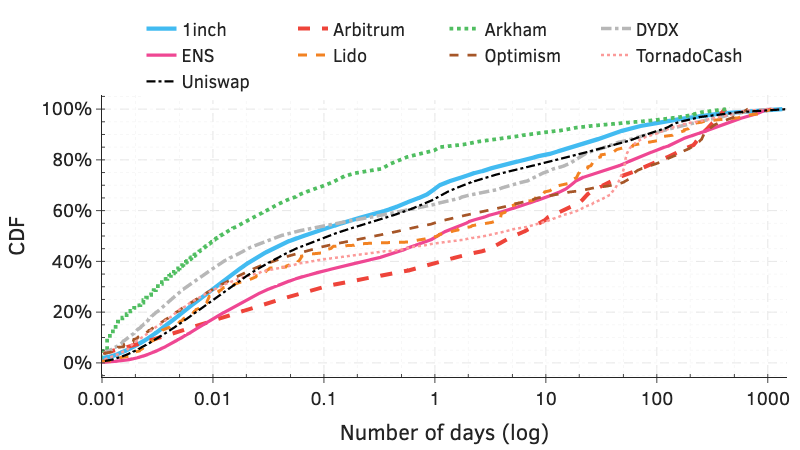

In [111]:
from math import log10
fig = go.Figure(layout=get_plotly_layout(width=800, height=450))
max_number_of_days = 0
for protocol in protocols:
    ecdf = ECDF(hops_dfs['time'][protocol]['hops'])
    max_number_of_days = max(max_number_of_days, max(ecdf.x))
    fig.add_trace(go.Scatter(x=ecdf.x,
                             y=ecdf.y,
                             name=plot_settings[protocol]['label'],
                             line=dict(
                                 color=plot_settings[protocol]['color'],
                                 width=plot_settings[protocol]['width'],
                                 dash=plot_settings[protocol]['style']
                             )))

fig.update_layout(
    xaxis_title='Number of days (log)',
    yaxis_title='CDF',
    legend=dict(xanchor='center', x=0.5, y=1.3, orientation='h'))

# fig.update_xaxes(type='log', range=[0.0000001, log10(max_number_of_days)])
fig.update_xaxes(type='log', range=[log10(0.001), log10(
    max_number_of_days)],  tickvals=[0.001, 0.01, 0.1, 1, 10, 100, 1000, 1500])
fig.update_yaxes(tickformat=".0%")
output_path = os.path.join(plots_dir, "number_of_days_until_exchange_log.pdf")
fig.write_image(output_path)
fig.show("png")

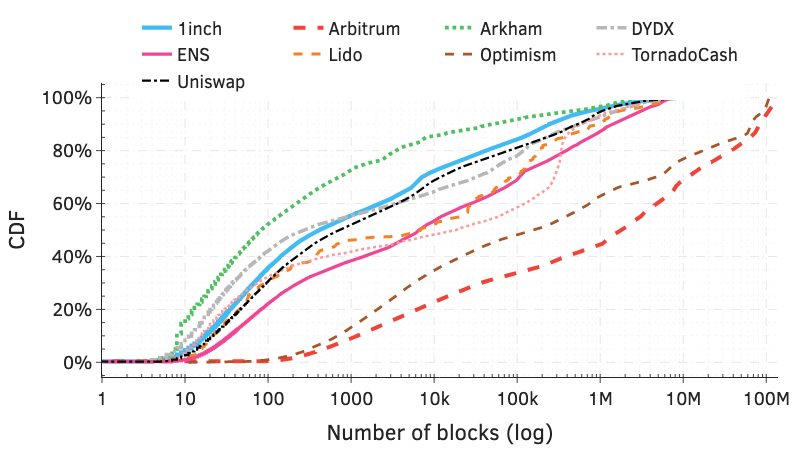

In [64]:
fig = go.Figure(layout=get_plotly_layout(width=800, height=450))
for protocol in protocols:
    ecdf = ECDF(hops_dfs['blocks'][protocol]['hops'])
    fig.add_trace(go.Scatter(x=ecdf.x, y=ecdf.y, name=plot_settings[protocol]['label'],
                             line=dict(color=plot_settings[protocol]['color'],
                             width=plot_settings[protocol]['width'],
                             dash=plot_settings[protocol]['style'])))

fig.update_layout(
    xaxis_title='Number of blocks (log)',
    yaxis_title='CDF',
    legend=dict(xanchor='center', x=0.5, y=1.25, orientation='h'))

fig.update_xaxes(type='log')
fig.update_yaxes(tickformat=".0%")
output_path = os.path.join(
    plots_dir, "number_of_blocks_until_exchange_log.pdf")
fig.write_image(output_path)
fig.show("png")

In [39]:
def analyze_airdrop_interactions(dfs, exchange_addresses_set):

    for protocol, dataframe in dfs.items():
        print(protocol)
        # Extract unique claimants using lazy operations
        claimant_df = dataframe['claim'].select('receiver').unique().collect()

        # Filter and aggregate data using lazy operations
        data = (
            dataframe['transfer']
            .filter(
                (pl.col('sender').is_in(claimant_df['receiver'])) &
                (pl.col('receiver').is_in(exchange_addresses_set))
            )
            .group_by('sender')
            .agg(pl.len().alias('count'))
            .sort(by='count', descending=True)
            .collect()
        )

        # Calculate descriptive statistics
        display(data['count'].to_pandas().describe().to_frame().T)


analyze_airdrop_interactions(dfs, exchange_addresses_set)

1inch


,count,mean,std,min,25%,50%,75%,max
count,26389.0,2.640418,17.65182,1.0,1.0,1.0,2.0,2695.0


arbitrum


,count,mean,std,min,25%,50%,75%,max
count,235346.0,4.106482,54.917663,1.0,1.0,2.0,3.0,19336.0


arkham


,count,mean,std,min,25%,50%,75%,max
count,10116.0,1.053084,0.356355,1.0,1.0,1.0,1.0,14.0


dydx


,count,mean,std,min,25%,50%,75%,max
count,16383.0,2.388879,3.718956,1.0,1.0,1.0,2.0,196.0


ens


,count,mean,std,min,25%,50%,75%,max
count,53717.0,1.779865,1.897908,1.0,1.0,1.0,2.0,107.0


lido


,count,mean,std,min,25%,50%,75%,max
count,395.0,4.210127,8.02274,1.0,1.0,2.0,4.0,132.0


optimism


,count,mean,std,min,25%,50%,75%,max
count,98168.0,4.711067,59.490654,1.0,1.0,1.0,4.0,16065.0


tornado


,count,mean,std,min,25%,50%,75%,max
count,2951.0,2.001694,3.433879,1.0,1.0,1.0,2.0,53.0


uniswap


,count,mean,std,min,25%,50%,75%,max
count,118880.0,3.101657,187.068918,1.0,1.0,1.0,2.0,63409.0


## Analyses of the number of hops it takes for addresses to reach an exchange.


In [ ]:
# Adding the or block number to the list of claimants?

In [ ]:
# Analyses of the number of hops it takes for addresses to reach an exchange.
target_addresses = exchange_addresses_set.copy()
with open(os.path.join(data_dir, "exchanges_addresses.json"), "w") as f:
    json.dump(list(target_addresses), f)

claim_receivers = dict()
for protocol, data in dfs.items():
    claim_receivers[protocol] = data['claim'].select(
        pl.col("receiver").unique()
    ).collect()['receiver'].to_list()

with open(os.path.join(data_dir, "claim_receivers_addresses.json"), "w") as f:
    json.dump(claim_receivers, f)

In [40]:
def load_hop_distribution_files():
    hop_distribution = dict()
    for protocol in tqdm(protocols, desc="Loading files..."):
        filepath = os.path.join(data_dir, f"hop_distribution_{protocol}.json")
        if os.path.isfile(filepath):
            with open(filepath) as f:
                hop_distribution[protocol] = json.load(f)
    return hop_distribution

In [41]:
hop_distribution = load_hop_distribution_files()
print(hop_distribution.keys())

Loading files...:   0%|          | 0/9 [00:00<?, ?it/s]

dict_keys(['1inch', 'arbitrum', 'arkham', 'dydx', 'ens', 'lido', 'optimism', 'tornado', 'uniswap'])


In [42]:
# Distribution of hops for airdrop recipients connecting with exchanges
hops_dfs = {}
for protocol in hop_distribution:
    print(protocol)
    hops_dfs[protocol] = pd.Series(
        hop_distribution[protocol])
    display(hops_dfs[protocol].describe(percentiles=percentiles).to_frame().T)

1inch


,count,mean,std,min,1%,5%,10%,20%,25%,50%,75%,80%,90%,95%,99%,max
0,42503.0,1.420888,0.579839,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,3.0,7.0


arbitrum


,count,mean,std,min,1%,5%,10%,20%,25%,50%,75%,80%,90%,95%,99%,max
0,567261.0,1.686571,0.731133,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,3.0,4.0,31.0


arkham


,count,mean,std,min,1%,5%,10%,20%,25%,50%,75%,80%,90%,95%,99%,max
0,60503.0,2.758574,5.36892,1.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,3.0,35.0,79.0


dydx


,count,mean,std,min,1%,5%,10%,20%,25%,50%,75%,80%,90%,95%,99%,max
0,43646.0,1.755006,0.721966,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,3.0,3.0,4.0,17.0


ens


,count,mean,std,min,1%,5%,10%,20%,25%,50%,75%,80%,90%,95%,99%,max
0,91169.0,1.488181,1.030061,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,3.0,50.0


lido


,count,mean,std,min,1%,5%,10%,20%,25%,50%,75%,80%,90%,95%,99%,max
0,470.0,1.170213,0.408813,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,4.0


optimism


,count,mean,std,min,1%,5%,10%,20%,25%,50%,75%,80%,90%,95%,99%,max
0,153211.0,1.470371,0.938735,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,3.0,4.0,32.0


tornado


,count,mean,std,min,1%,5%,10%,20%,25%,50%,75%,80%,90%,95%,99%,max
0,4818.0,1.545662,0.815112,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,3.0,3.0,4.0,5.0


uniswap


,count,mean,std,min,1%,5%,10%,20%,25%,50%,75%,80%,90%,95%,99%,max
0,216401.0,1.55558,0.791422,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,3.0,5.0,16.0


In [43]:
# Airdrop receipients interacting with exchanges.
# Extract unique claimants using lazy operations
claimant_df = dfs[protocol]['claim'].select('receiver').unique().collect()

# Filter and aggregate data using lazy operations
data = (
    dfs[protocol]['transfer']
    .filter(
        (pl.col('sender').is_in(claimant_df['receiver'])) &
        (pl.col('receiver').is_in(exchange_addresses_set))
    )
    .select(pl.col('sender').value_counts(sort=True))
    .collect()
)
data

sender
struct[2]
"{""0x56178a0d5f301baf6cf3e1cd53d9863437345bf9"",63409}"
"{""0xa57bd00134b2850b2a1c55860c9e9ea100fdd6cf"",8755}"
"{""0x22f9dcf4647084d6c31b2765f6910cd85c178c18"",3899}"
"{""0x005561e55a65d8477f1c407606c90e1f6d8398a9"",3227}"
"{""0x860bd2dba9cd475a61e6d1b45e16c365f6d78f66"",2773}"
…
"{""0xb5c4fb78d9a7cb0afa491266a66c6c293991e74e"",1}"
"{""0x61578c3f558f89786aad724284ea96a310772d4a"",1}"
"{""0x2cdb19135a2beb8a89f1faac0771c2f95f34eb08"",1}"


In [44]:
for protocol, dataframe in dfs.items():
    claimant_df = dataframe['claim'].select('receiver').unique().collect()

    # Filter and aggregate data using lazy operations
    data = (
        dataframe['transfer']
        .filter(
            (pl.col('sender').is_in(claimant_df['receiver'])) &
            (pl.col('receiver').is_in(exchange_addresses_set))
        )
        .select(pl.col('sender').unique())
        .collect()
    )
    print(protocol, data.shape)

1inch (26389, 1)
arbitrum (235346, 1)
arkham (10116, 1)
dydx (16383, 1)
ens (53717, 1)
lido (395, 1)
optimism (98168, 1)
tornado (2951, 1)
uniswap (118880, 1)


In [45]:
def analyze_airdrop_interactions_with_exchanges(dfs, exchange_addresses_set):

    for protocol, dataframe in dfs.items():
        print(protocol)
        # Extract unique claimants using lazy operations
        claimant_df = dataframe['claim'].select('receiver').unique().collect()

        # Filter and aggregate data using lazy operations
        data = (
            dataframe['transfer']
            .filter(
                (pl.col('sender').is_in(claimant_df['receiver'])) &
                (pl.col('receiver').is_in(exchange_addresses_set))
            )
            .group_by('sender')
            .agg(pl.len().alias('count'))
            .sort(by='count', descending=True)
            .collect()
        )

        # Calculate descriptive statistics
        display(data['count'].to_pandas().describe(
            percentiles=percentiles).to_frame().T)


analyze_airdrop_interactions_with_exchanges(dfs, exchange_addresses_set)

1inch


,count,mean,std,min,1%,5%,10%,20%,25%,50%,75%,80%,90%,95%,99%,max
count,26389.0,2.640418,17.65182,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,3.0,5.0,7.0,20.0,2695.0


arbitrum


,count,mean,std,min,1%,5%,10%,20%,25%,50%,75%,80%,90%,95%,99%,max
count,235346.0,4.106482,54.917663,1.0,1.0,1.0,1.0,1.0,1.0,2.0,3.0,4.0,7.0,12.0,34.0,19336.0


arkham


,count,mean,std,min,1%,5%,10%,20%,25%,50%,75%,80%,90%,95%,99%,max
count,10116.0,1.053084,0.356355,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,14.0


dydx


,count,mean,std,min,1%,5%,10%,20%,25%,50%,75%,80%,90%,95%,99%,max
count,16383.0,2.388879,3.718956,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,3.0,5.0,7.0,16.0,196.0


ens


,count,mean,std,min,1%,5%,10%,20%,25%,50%,75%,80%,90%,95%,99%,max
count,53717.0,1.779865,1.897908,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,3.0,5.0,9.0,107.0


lido


,count,mean,std,min,1%,5%,10%,20%,25%,50%,75%,80%,90%,95%,99%,max
count,395.0,4.210127,8.02274,1.0,1.0,1.0,1.0,1.0,1.0,2.0,4.0,5.0,8.6,13.3,27.24,132.0


optimism


,count,mean,std,min,1%,5%,10%,20%,25%,50%,75%,80%,90%,95%,99%,max
count,98168.0,4.711067,59.490654,1.0,1.0,1.0,1.0,1.0,1.0,1.0,4.0,5.0,9.0,16.0,45.0,16065.0


tornado


,count,mean,std,min,1%,5%,10%,20%,25%,50%,75%,80%,90%,95%,99%,max
count,2951.0,2.001694,3.433879,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,3.0,6.0,15.5,53.0


uniswap


,count,mean,std,min,1%,5%,10%,20%,25%,50%,75%,80%,90%,95%,99%,max
count,118880.0,3.101657,187.068918,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,3.0,4.0,6.0,14.0,63409.0


### Transfers of that token to anyone but overtime!


In [ ]:
# Check also for number of days between the first and last transaction. Also report the distribution of the numbe of transactions.

In [ ]:
# fig = go.Figure(layout=get_plotly_layout(width=800, height=450))
# for protocol, dataframe in dfs.items():
#     print(protocol)
#     # Extract unique claimants using lazy operations
#     claimant_df = dataframe['claim'].select('receiver').unique().collect()
#     data = (
#         dataframe['transfer']
#         .filter(
#             (pl.col('sender').is_in(claimant_df['receiver'])) &
#             (~pl.col('receiver').is_in(dead_address_set))
#         )
#         .with_columns(pl.col('timestamp').cast(pl.Date).alias('date'))
#         .group_by(['sender', 'date'])
#         .agg(pl.len())
#         .sort(by=['len', 'sender'], descending=True)
#         .with_row_index(name="days_since_start")
#         .collect()
#     )

#     fig.add_trace(
#         go.Scatter(
#             mode='markers',
#             x=data['days_since_start'],
#             y=data['len'],
#             marker=dict(
#                 color=plot_settings[protocol]['color'],
#                 size=10,
#                 line=dict(
#                     color='MediumPurple',
#                     width=1
#                 )
#             ),
#             name=protocol.capitalize()
#         )
#     )

# # Update layout
# fig.update_layout(
#     xaxis_title="Days since start",
#     yaxis_title="Number of transfers",
#     # legend=dict(xanchor="center", x=0.5, y=1.35, orientation="h")
# )

# fig.show('png')

In [ ]:
# # Setup figure
# fig = go.Figure(layout=get_plotly_layout(width=800, height=450))

# for protocol, dataframe in dfs.items():
#     claimant_df = dataframe['claim'].select('receiver').unique().collect()
#     data = (
#         dataframe['transfer']
#         .filter(
#             (pl.col('sender').is_in(claimant_df['receiver'])) &
#             (~pl.col('receiver').is_in(dead_address_set))
#         )
#         .with_columns(pl.col('timestamp').cast(pl.Date).alias('date'))
#         .group_by(['sender', 'date'])
#         .agg(pl.len().alias("daily_transfers_sum"))
#         .sort("date")
#         .with_columns([
#             pl.col("daily_transfers_sum").cum_sum().alias("cumulative_sum"),
#             pl.col("daily_transfers_sum").sum().alias("total_sum")
#         ])
#         .with_columns(
#             (pl.col("cumulative_sum") / pl.col("total_sum")).alias("transfer_fraction")
#         )
#         .with_row_index(name="days_since_start")
#         .select(["days_since_start", "transfer_fraction"])
#         .collect()
#     )

#     fig.add_trace(go.Scatter(
#         x=data["days_since_start"],
#         y=data["transfer_fraction"],
#         mode="lines",
#         line=dict(
#             color=plot_settings[protocol]['color'],
#             width=plot_settings[protocol]['width'],
#             dash=plot_settings[protocol]['style']
#         ),
#         name=plot_settings[protocol]['label']
#     ))

# # Update layout
# fig.update_layout(
#     xaxis_title="Number of days",
#     yaxis_title="Percentage of number of transfers",
#     legend=dict(xanchor="center", x=0.5, y=1.35, orientation="h"))

# fig.update_xaxes(type="log")
# # fig.update_yaxes(tickformat=".0%", range=[0, 1])

# # Export and display
# # fig.write_image(os.path.join(plots_dir, "tokens_claimed_per_day.pdf"))
# fig.show('png')

In [ ]:
# def analyze_airdrop_interactions(dfs):

#     for protocol, dataframe in dfs.items():
#         print(protocol)
#         # Extract unique claimants using lazy operations
#         claimant_df = dataframe['claim'].select('receiver').unique().collect()

#         # Filter and aggregate data using lazy operations
#         data = (
#             dataframe['transfer']
#             .filter(
#                 (pl.col('sender').is_in(claimant_df['receiver'])) &
#                 (~pl.col('receiver').is_in(dead_address_set))
#             )
#             .with_columns(pl.col('timestamp').cast(pl.Date).alias('date'))
#             .group_by(['sender', 'date'])
#             .agg(pl.len())
#             .sort(by=['len', 'sender'], descending=True)
#             .collect()
#         )

#         # Calculate descriptive statistics
#         display(data)


# analyze_airdrop_interactions(dfs)

In [46]:
dfs['ens']['transfer'].filter(~pl.col('sender').is_in(
    dataframe['claim'].select('receiver').unique().collect())).collect().shape

(930271, 11)

In [47]:
for protocol, dataframe in dfs.items():
    claimant_df = dataframe['claim'].select('receiver').unique().collect()
    data = dataframe['transfer'].filter(
        (pl.col('sender').is_in(claimant_df['receiver'])) &
        (~pl.col('receiver').is_in(dead_address_set))
    ).collect()
    print(protocol, data.shape[0])

1inch 109231
arbitrum 2451945
arkham 68027
dydx 98654
ens 159286
lido 2041
optimism 744397
tornado 9057
uniswap 811558


In [48]:
# Shows the distribution of the total number of transfers.
for protocol, dataframe in dfs.items():

    # Extract unique claimants using lazy operations
    claimant_df = dataframe['claim'].select('receiver').unique().collect()

    # Filter and aggregate data using lazy operations
    data = (
        dataframe['transfer']
        .filter(
            (pl.col('sender').is_in(claimant_df['receiver'])) &
            (~pl.col('receiver').is_in(dead_address_set))
        )
        .group_by('sender')
        .agg(pl.len().alias('count'))
        .sort(by='count', descending=True)
        .collect()
    )
    print(protocol, data['count'].sum(), data['sender'].n_unique(
    ), claimant_df.shape[0], claimant_df.shape[0] - data['sender'].n_unique(),
        round(100*data['sender'].n_unique()/claimant_df.shape[0], 2))

    # Calculate descriptive statistics
    display(data['count'].to_pandas().describe(
        percentiles=percentiles).to_frame().T)

1inch 109231 42759 43806 1047 97.61


,count,mean,std,min,1%,5%,10%,20%,25%,50%,75%,80%,90%,95%,99%,max
count,42759.0,2.554573,17.544703,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,3.0,5.0,7.0,19.0,3195.0


arbitrum 2451945 570450 583137 12687 97.82


,count,mean,std,min,1%,5%,10%,20%,25%,50%,75%,80%,90%,95%,99%,max
count,570450.0,4.298265,89.448172,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,4.0,7.0,12.0,35.0,40771.0


arkham 68027 64032 64719 687 98.94


,count,mean,std,min,1%,5%,10%,20%,25%,50%,75%,80%,90%,95%,99%,max
count,64032.0,1.062391,0.424525,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,58.0


dydx 98654 44773 45944 1171 97.45


,count,mean,std,min,1%,5%,10%,20%,25%,50%,75%,80%,90%,95%,99%,max
count,44773.0,2.203426,3.518509,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,3.0,5.0,7.0,16.0,214.0


ens 159286 93506 102824 9318 90.94


,count,mean,std,min,1%,5%,10%,20%,25%,50%,75%,80%,90%,95%,99%,max
count,93506.0,1.703484,1.82649,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,3.0,4.0,8.0,117.0


lido 2041 471 507 36 92.9


,count,mean,std,min,1%,5%,10%,20%,25%,50%,75%,80%,90%,95%,99%,max
count,471.0,4.333333,8.903103,1.0,1.0,1.0,1.0,1.0,1.0,2.0,4.0,5.0,8.0,14.5,31.3,147.0


optimism 744397 154209 160603 6394 96.02


,count,mean,std,min,1%,5%,10%,20%,25%,50%,75%,80%,90%,95%,99%,max
count,154209.0,4.827196,51.791498,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,4.0,9.0,17.0,51.0,16089.0


tornado 9057 4900 5347 447 91.64


,count,mean,std,min,1%,5%,10%,20%,25%,50%,75%,80%,90%,95%,99%,max
count,4900.0,1.848367,5.590728,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,3.0,5.0,13.0,327.0


uniswap 811558 217635 221087 3452 98.44


,count,mean,std,min,1%,5%,10%,20%,25%,50%,75%,80%,90%,95%,99%,max
count,217635.0,3.728987,228.289399,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,3.0,4.0,7.0,15.0,84328.0


In [49]:
# Shows the total number of days it took from the first transfer to the last.
for protocol, dataframe in dfs.items():
    # Extract unique claimants using lazy operations
    claimant_df = dataframe['claim'].select('receiver').unique().collect()
    data = (
        dataframe['transfer']
        .filter(
            (pl.col('sender').is_in(claimant_df['receiver'])) &
            (~pl.col('receiver').is_in(dead_address_set))
        )
        .group_by(['sender'])
        .agg(((pl.col('timestamp').max() - pl.col('timestamp').min()).dt.total_seconds()/3600/24).alias('total_days'))
        # .agg((pl.col('timestamp').max() - pl.col('timestamp').min()).dt.total_days().alias('total_days'))
        .sort(by='total_days', descending=True)
        .collect()
    )
    print(protocol, data.shape)

    # Calculate descriptive statistics
    display(data['total_days'].to_pandas().describe(
        percentiles=percentiles).to_frame().T)

1inch (42759, 2)


,count,mean,std,min,1%,5%,10%,20%,25%,50%,75%,80%,90%,95%,99%,max
total_days,42759.0,62.75536,190.175897,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.187743,38.619935,151.703836,423.373226,1074.359495,1388.778611


arbitrum (570450, 2)


,count,mean,std,min,1%,5%,10%,20%,25%,50%,75%,80%,90%,95%,99%,max
total_days,570450.0,86.65098,135.997265,0.0,0.0,0.0,0.0,0.0,0.0,0.0,157.126461,234.426468,340.750986,380.449442,409.65034,418.426285


arkham (64032, 2)


,count,mean,std,min,1%,5%,10%,20%,25%,50%,75%,80%,90%,95%,99%,max
total_days,64032.0,2.9345,27.838297,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,88.750232,458.574444


dydx (44773, 2)


,count,mean,std,min,1%,5%,10%,20%,25%,50%,75%,80%,90%,95%,99%,max
total_days,44773.0,84.379132,198.325346,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.470683,85.162914,327.321745,587.948384,894.65274,1136.167002


ens (93506, 2)


,count,mean,std,min,1%,5%,10%,20%,25%,50%,75%,80%,90%,95%,99%,max
total_days,93506.0,57.790673,175.264543,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.456916,15.344583,160.864716,420.879268,942.425166,1074.289687


lido (471, 2)


,count,mean,std,min,1%,5%,10%,20%,25%,50%,75%,80%,90%,95%,99%,max
total_days,471.0,231.165886,348.807088,0.0,0.0,0.0,0.0,0.0,0.0,42.615822,315.444821,538.184005,824.16169,1047.547089,1223.090131,1348.973183


optimism (154209, 2)


,count,mean,std,min,1%,5%,10%,20%,25%,50%,75%,80%,90%,95%,99%,max
total_days,154209.0,163.631479,222.19945,0.0,0.0,0.0,0.0,0.0,0.0,0.0,298.4239,388.892634,568.998431,618.348863,654.931372,663.207384


tornado (4900, 2)


,count,mean,std,min,1%,5%,10%,20%,25%,50%,75%,80%,90%,95%,99%,max
total_days,4900.0,20.174353,92.567987,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.006292,18.255307,111.416138,514.831031,1321.935949


uniswap (217635, 2)


,count,mean,std,min,1%,5%,10%,20%,25%,50%,75%,80%,90%,95%,99%,max
total_days,217635.0,64.931415,195.982602,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.873744,41.4576,183.381968,378.428762,1166.91316,1493.329965


In [50]:
for protocol, dataframe in dfs.items():
    data = (
        dfs[protocol]['claim']
        .group_by('receiver')
        .agg(pl.len())
        .sort('len', descending=True)
        .filter(pl.col('len') > 1)
        .collect()
    )
    if data.shape[0] > 0:
        print(protocol, data.shape)
        display(data)

arkham (5, 2)


receiver,len
str,u32
"""0x8dbf815dc6d182ebe67520379663…",2
"""0x668540812466219a4cf9ef22151b…",2
"""0x3bd07bcba7383da29d95fb7d72d2…",2
"""0x83ec3ccbc9c13d3ba2b17246c23c…",2
"""0x9f0cd1fc4e464a9a0573639b36db…",2


dydx (10041, 2)


receiver,len
str,u32
"""0xdadeff709cd9e0e2a94bbfb6532b…",30
"""0x0d3fce41412c4f80e970c920ade1…",29
"""0xfc36ecaebfc07b838f3a249f851f…",28
"""0xb36de934a9f4bcd6770c4bf633f9…",28
"""0xd401edab3ac122462dfee34e6504…",27
…,…
"""0x15ba9d87ace05adf00d4b8ff17b3…",2
"""0x6edfe792896bc0624d14c1c076a5…",2
"""0xf224cda8d665155c47a5e12d4c83…",2


lido (9, 2)


receiver,len
str,u32
"""0x34a7df36e5a098dea126072661fe…",2
"""0x32254b28f793cc18b3575c86c61f…",2
"""0xefe75bc70e9ed3be4717036d7588…",2
"""0xc50e1c84128fdefcddc26543384b…",2
"""0xc54570b8eb8138ace95132b944b7…",2
"""0x51d679666d6a24653f1fae57a8b1…",2
"""0x3cacb4468b53fba62bb30ed5975a…",2
"""0xdf632ea5ba8283488aae8538e17a…",2
"""0x1a91c0df156a5f38aec0813d055a…",2


tornado (99, 2)


receiver,len
str,u32
"""0x17b81c99f190d344e07d9dc9cc09…",16
"""0x75c43cc45605654a3760569567b8…",4
"""0x3e4517fe3cd35feefa0147b12f29…",4
"""0x5737c48e0f88c8cf5174ead1b78c…",4
"""0x5efda50f22d34f262c29268506c5…",3
…,…
"""0xc56ad0c9ca0b3c855144dcef9d63…",2
"""0xb6ee85a39ffc814595228d0710d3…",2
"""0x9f2bffaa271076391e1f8f3c4ac8…",2


In [51]:
for protocol, dataframe in dfs.items():
    print(protocol)
    claimant_df = (
        dfs[protocol]['claim']
        .group_by('receiver')
        .agg(pl.len())
        .sort('len', descending=True)
    ).collect()
    display(claimant_df.to_pandas()['len'].describe(
        percentiles=percentiles).to_frame().T)

1inch


,count,mean,std,min,1%,5%,10%,20%,25%,50%,75%,80%,90%,95%,99%,max
len,43806.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


arbitrum


,count,mean,std,min,1%,5%,10%,20%,25%,50%,75%,80%,90%,95%,99%,max
len,583137.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


arkham


,count,mean,std,min,1%,5%,10%,20%,25%,50%,75%,80%,90%,95%,99%,max
len,64719.0,1.000077,0.008789,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0


dydx


,count,mean,std,min,1%,5%,10%,20%,25%,50%,75%,80%,90%,95%,99%,max
len,45944.0,1.586061,1.681892,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,3.0,4.0,9.0,30.0


ens


,count,mean,std,min,1%,5%,10%,20%,25%,50%,75%,80%,90%,95%,99%,max
len,102824.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


lido


,count,mean,std,min,1%,5%,10%,20%,25%,50%,75%,80%,90%,95%,99%,max
len,507.0,1.017751,0.132177,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0


optimism


,count,mean,std,min,1%,5%,10%,20%,25%,50%,75%,80%,90%,95%,99%,max
len,160603.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


tornado


,count,mean,std,min,1%,5%,10%,20%,25%,50%,75%,80%,90%,95%,99%,max
len,5347.0,1.023752,0.262361,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,16.0


uniswap


,count,mean,std,min,1%,5%,10%,20%,25%,50%,75%,80%,90%,95%,99%,max
len,221087.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [52]:
for protocol, dataframe in dfs.items():
    print(protocol)
    # Extract unique claimants using lazy operations
    # claimant_df = dataframe['claim'].select('receiver').unique().collect()

    # Collect the data once, minimizing unnecessary collects
    claimant_df = dfs[protocol]['claim'].select(
        ['receiver', 'blockNumber', 'timestamp']).rename({"timestamp": "claiming_timestamp", "blockNumber": "claiming_block"}).collect()

    # Create the dictionary
    claimant_dict = {row['receiver']: {"block_number": row['claiming_block'],
                                       "timestamp": row['claiming_timestamp']} for row in claimant_df.iter_rows(named=True)}

    data = (
        dataframe['transfer']
        .filter(
            (pl.col('sender').is_in(claimant_df['receiver'])) &
            (pl.col('receiver').is_in(exchange_addresses_set))
        )
        .select(['sender', 'blockNumber', 'timestamp'])
        # .group_by(['sender'])
        # .agg((pl.col('timestamp').max() - pl.col('timestamp').min()).dt.total_days().alias('total_days'))
        # .sort(by='total_days', descending=True)
        .collect()
    )
    data_merged = (
        data.join(claimant_df, left_on="sender",
                  right_on="receiver", how="left")
        .unique(subset=['sender'], keep='first', maintain_order=True)
        .select((pl.col('timestamp') - pl.col('claiming_timestamp')).dt.total_days().alias('total_days'))
        # .filter(pl.col("total_days").ge(0))
    )

    # Calculate descriptive statistics
    display(data_merged['total_days'].to_pandas().describe(
        percentiles=percentiles).to_frame().T)

1inch


,count,mean,std,min,1%,5%,10%,20%,25%,50%,75%,80%,90%,95%,99%,max
total_days,26389.0,23.93088,107.993826,-1129.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,6.0,37.0,112.0,607.0,1352.0


arbitrum


,count,mean,std,min,1%,5%,10%,20%,25%,50%,75%,80%,90%,95%,99%,max
total_days,235346.0,60.914951,106.865325,-181.0,0.0,0.0,0.0,0.0,0.0,5.0,57.0,113.0,252.0,328.0,390.0,418.0


arkham


,count,mean,std,min,1%,5%,10%,20%,25%,50%,75%,80%,90%,95%,99%,max
total_days,10116.0,11.229933,47.609683,-5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,62.25,267.85,456.0


dydx


,count,mean,std,min,1%,5%,10%,20%,25%,50%,75%,80%,90%,95%,99%,max
total_days,16383.0,35.907587,138.451851,-1029.0,-237.0,0.0,0.0,0.0,0.0,0.0,17.0,28.0,115.0,281.8,682.18,1091.0


ens


,count,mean,std,min,1%,5%,10%,20%,25%,50%,75%,80%,90%,95%,99%,max
total_days,53717.0,68.819033,172.723992,-174.0,0.0,0.0,0.0,0.0,0.0,1.0,30.0,60.0,218.4,454.0,872.0,1073.0


lido


,count,mean,std,min,1%,5%,10%,20%,25%,50%,75%,80%,90%,95%,99%,max
total_days,395.0,-2.941772,195.670938,-1215.0,-845.18,-101.0,-58.0,-30.0,-29.0,0.0,4.0,11.2,40.6,176.0,874.06,1099.0


optimism


,count,mean,std,min,1%,5%,10%,20%,25%,50%,75%,80%,90%,95%,99%,max
total_days,98168.0,69.212248,137.486752,-378.0,0.0,0.0,0.0,0.0,0.0,0.0,63.0,118.0,261.0,382.0,602.33,662.0


tornado


,count,mean,std,min,1%,5%,10%,20%,25%,50%,75%,80%,90%,95%,99%,max
total_days,2951.0,45.460522,114.253395,-246.0,0.0,0.0,0.0,0.0,0.0,2.0,49.0,52.0,94.0,230.5,551.5,1248.0


uniswap


,count,mean,std,min,1%,5%,10%,20%,25%,50%,75%,80%,90%,95%,99%,max
total_days,118880.0,31.854223,119.445093,-1349.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,12.0,81.0,161.0,635.21,1490.0
